# 🎯 Exclusive π⁰ Reconstruction — NPS Experiment (2023–2024)

## ✨ Physics Motivation

We aim to extract the **exclusive cross section** for the process:

$
e + p \rightarrow e' + \pi^0 + p'
$

in which:
- The scattered electron is detected in the **HMS**.
- The two photons from π⁰ decay (π⁰ → γγ) are detected in the **NPS**.
- We do **not detect the recoil proton**, so we will apply an **exclusive cut** based on the **missing mass = proton mass**.

---

## 📁 Data Summary

- **Experiment**: NPS run group (Sept 2023 – May 2024)
- **Input**: Skimmed ROOT files located at  
  `/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/pi0_skimmed/`
- **Event structure**: one electron in HMS and two neutral clusters in NPS


In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.135  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")


In [3]:
# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

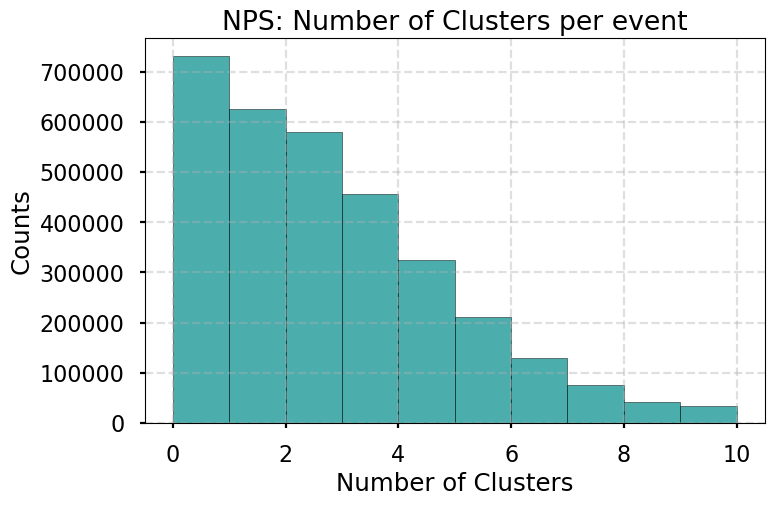

In [22]:
nclust = ak.to_numpy(branches["NPS.cal.nclust"])

plt.figure(figsize=(8, 5))
plt.hist(nclust, bins=np.arange(0, 10.5, 1), color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Number of Clusters")
plt.ylabel("Counts")
plt.title("NPS: Number of Clusters per event")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


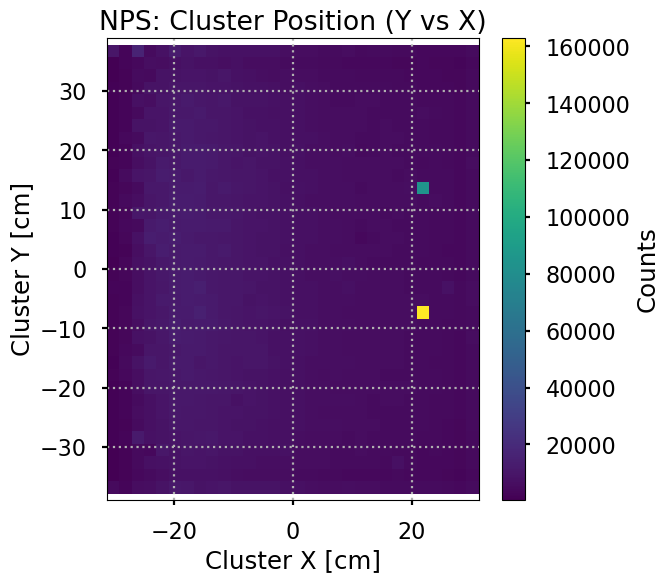

In [23]:
clusX = ak.to_numpy(ak.flatten(branches["NPS.cal.clusX"]))
clusY = ak.to_numpy(ak.flatten(branches["NPS.cal.clusY"]))

# clusX = ak.to_numpy((branches["NPS.cal.clusX"][:1]))
# clusY = ak.to_numpy((branches["NPS.cal.clusY"][:1]))

plt.figure(figsize=(6,6))
plt.hist2d(clusX, clusY, bins=(30,36), cmap='viridis')
plt.xlabel("Cluster X [cm]")
plt.ylabel("Cluster Y [cm]")
plt.title("NPS: Cluster Position (Y vs X)")
plt.colorbar(label="Counts")
plt.grid(True, linestyle=":")
plt.axis("equal")
plt.show()


In [6]:
clusX

array([ 20.98884291,   2.8744828 ,  17.19463612, ...,  14.04      ,
       -17.25477318, -18.36      ], shape=(8635667,))

No. of remaining clusters: 1321653


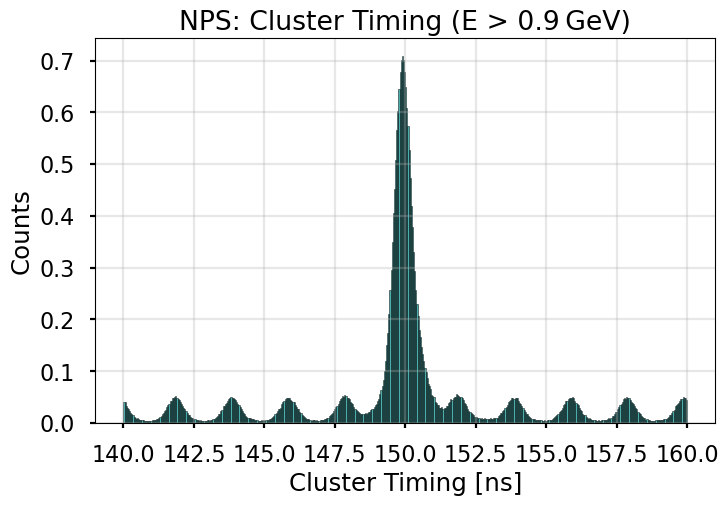

In [7]:
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply mask per cluster, preserving jagged structure
energy_cut = 0.9
mask = clusE > energy_cut

# Apply mask before flattening
clusT_selected = clusT[mask]

# Flatten to 1D array for histogramming
clusT_flat = ak.to_numpy(ak.flatten(clusT_selected))
print(f'No. of remaining clusters: {len(clusT_flat)}')
plt.figure(figsize=(8,5))
plt.hist(clusT_flat, bins=500, range=(140,160), density=True,
         color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Cluster Timing [ns]")
plt.ylabel("Counts")
plt.title(f'NPS: Cluster Timing (E > {energy_cut} GeV)')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_32750/3991225391.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  event_times_np = np.array(event_times)  # Convert to NumPy array


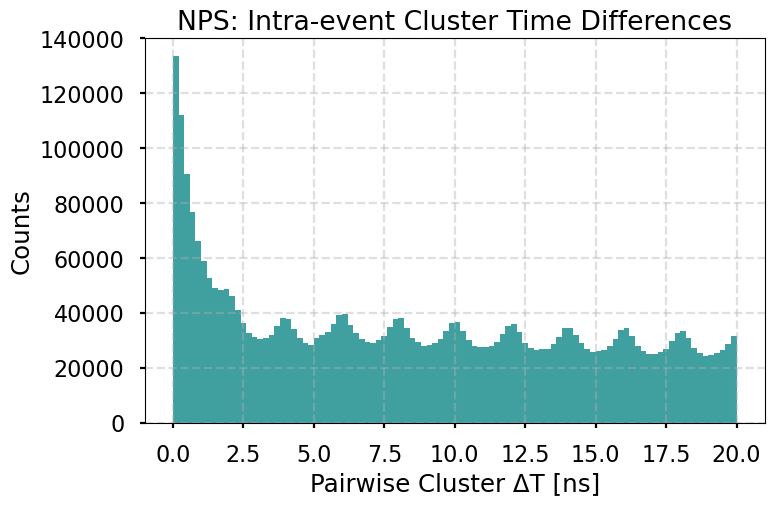

In [8]:
# plot pairwise time difference of the several instance of clusters associated to the same event.

clusT_all = branches["NPS.cal.clusT"]

time_diff = []

for event_times in clusT_all:
    event_times_np = np.array(event_times)  # Convert to NumPy array
    n = len(event_times_np)
    if n < 2:
        continue
    # Compute absolute pairwise time differences
    diffs = event_times_np[:, None] - event_times_np[None, :]
    triu = np.triu_indices(n, k=1)  # i < j to avoid duplicates and diagonal
    time_diff.extend(diffs[triu])

# Convert to NumPy array and plot
time_diff = np.array(time_diff)

plt.figure(figsize=(8,5))
plt.hist(time_diff, bins=100, range=(0, 20), color="teal", alpha=0.75)
plt.xlabel("Pairwise Cluster ΔT [ns]")
plt.ylabel("Counts")
plt.title("NPS: Intra-event Cluster Time Differences")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


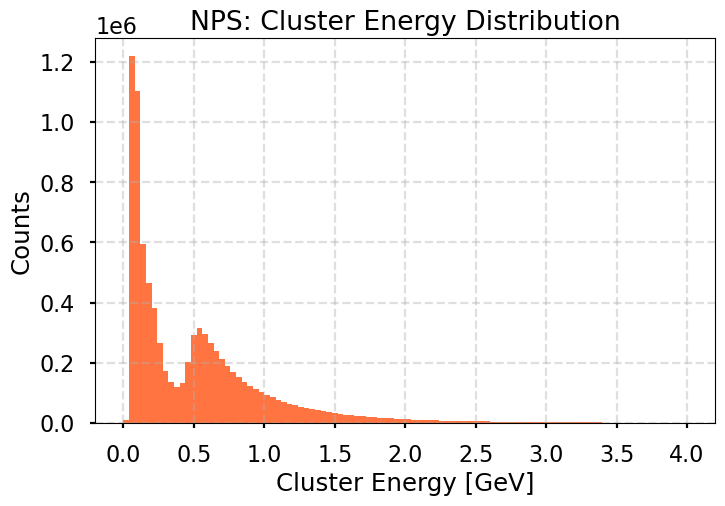

In [9]:
clusE = ak.to_numpy(ak.flatten(branches["NPS.cal.clusE"]))

plt.figure(figsize=(8,5))
plt.hist(clusE, bins=100, range=(0, 4), color="orangered", alpha=0.75)
plt.xlabel("Cluster Energy [GeV]")
plt.ylabel("Counts")
plt.title("NPS: Cluster Energy Distribution")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


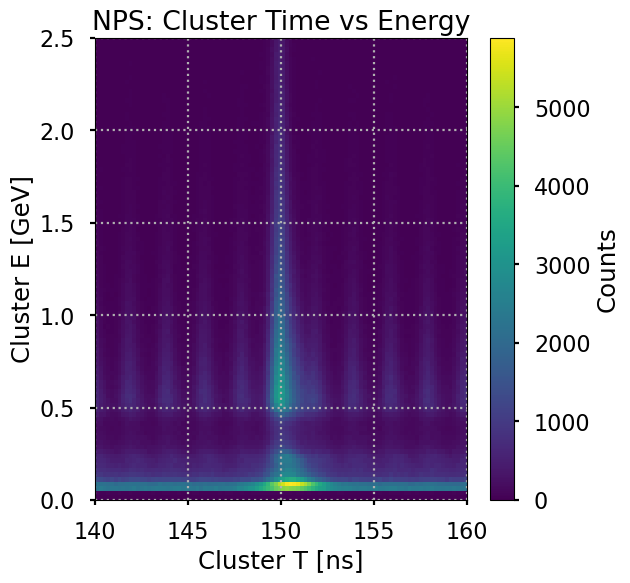

In [10]:
# Flatten jagged arrays to 1D NumPy arrays
clusT_flat = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
clusE_flat = ak.to_numpy(ak.flatten(branches["NPS.cal.clusE"]))

plt.figure(figsize=(6,6))
plt.hist2d(clusT_flat, clusE_flat,
           bins=[100, 100],
           range=[[140, 160], [0, 2.5]],
           cmap='viridis')
plt.xlabel("Cluster T [ns]")
plt.ylabel("Cluster E [GeV]")
plt.title("NPS: Cluster Time vs Energy")
plt.colorbar(label="Counts")
plt.grid(True, linestyle=":")
plt.show()


In [ ]:
def reconstruct_pi0_mass(event):
    energies = event["NPS.cal.clusE"]
    xs = event["NPS.cal.clusX"]
    ys = event["NPS.cal.clusY"]

    if len(energies) < 2:
        return None  # Not enough clusters

    # Take the two highest-energy clusters
    idx = np.argsort(energies)[-2:]
    e1, e2 = energies[idx[0]], energies[idx[1]]
    x1, y1 = xs[idx[0]], ys[idx[0]]
    x2, y2 = xs[idx[1]], ys[idx[1]]

    # Assume vertex at origin, NPS at fixed z
    z_nps = 4.07  # meters, placeholder
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    u1 = r1 / np.linalg.norm(r1)
    u2 = r2 / np.linalg.norm(r2)

    # Photon 3-momenta
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2
    m2 = total_E**2 - np.dot(total_p, total_p)
    return np.sqrt(m2) if m2 > 0 else 0.0


<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_259648/3976835230.py:11: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_259648/3976835230.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")


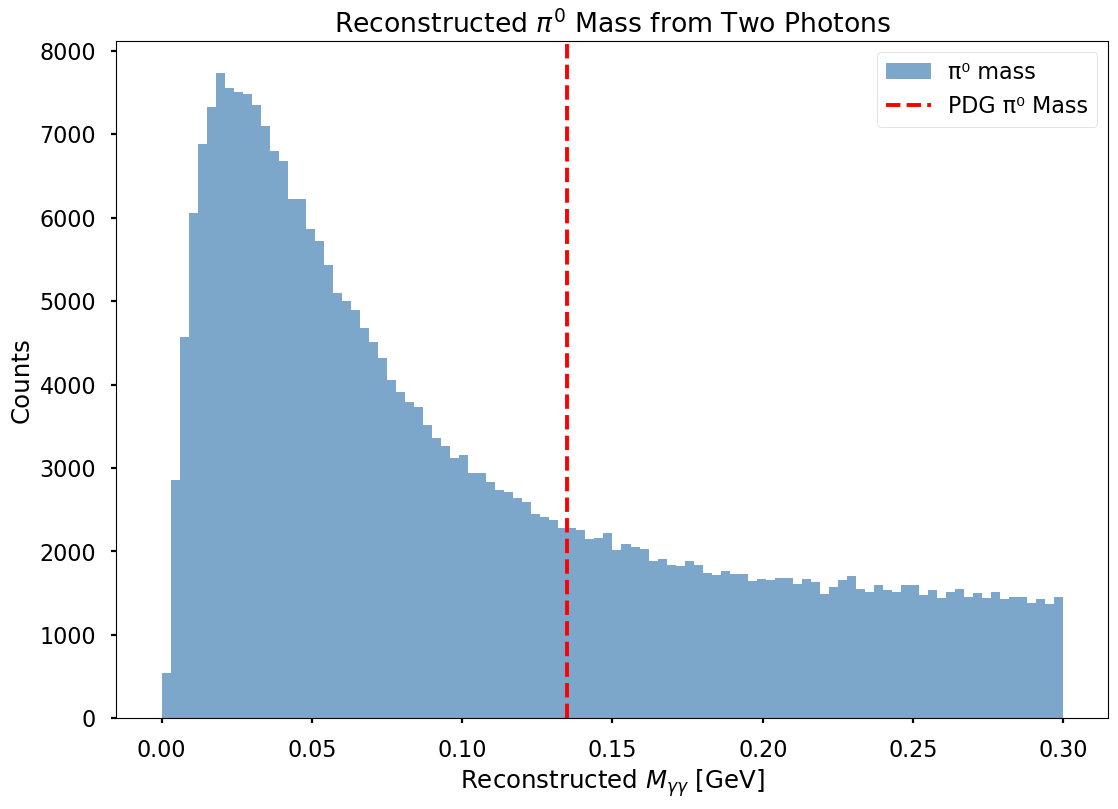

In [ ]:
pi0_masses = []

for evt in branches:
    m = reconstruct_pi0_mass(evt)
    if m:
        pi0_masses.append(m)

# Plot
plt.figure(figsize=(6,6))
plt.hist(pi0_masses, bins=100, range=(0, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()


In [11]:
# much faster (around 4x) with numba then the prev cells using just plain python

import numba as nb
import numpy as np

@nb.njit
def reconstruct_pi0_mass_fast(e1, e2, x1, y1, x2, y2, z_nps=4.07):
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2
    m2 = total_E**2 - np.dot(total_p, total_p)
    return np.sqrt(m2) if m2 > 0 else 0.0


<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_32750/1287418248.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_32750/1287418248.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
/tmp/ipykernel_32750/1287418248.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e = np.array(event["NPS.cal.clusE"])
/tmp/ipykernel_32750/1287418248.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=Fals

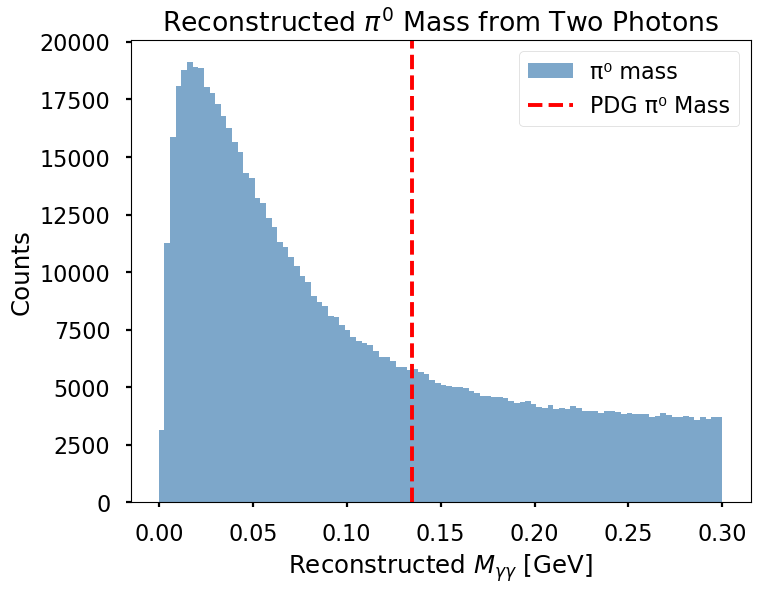

In [12]:
masses = []
for event in branches:  # loop over awkward array
    e = np.array(event["NPS.cal.clusE"])
    x = np.array(event["NPS.cal.clusX"])
    y = np.array(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast(e[idx[0]], e[idx[1]],
                                            x[idx[0]], y[idx[0]],
                                            x[idx[1]], y[idx[1]]))
    
# Plot
plt.figure(figsize=(8,6))
plt.hist(masses, bins=100, range=(0, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()


In [ ]:
# HMS time per event
hmsT = branches["T.hms.hEDTM_tdcTimeRaw"]
clusT = branches["NPS.cal.clusT"]

# Compute deltaT (cluster time - HMS time) per cluster
deltaT = clusT - hmsT  # This uses broadcasting via awkward arrays

# Coincidence window: 149–151 ns (~±1 ns from peak)
signal_mask = (deltaT > 149) & (deltaT < 151)

# Background windows (like your bgLo/bgHi)
bg_lo_mask = (deltaT > 113) & (deltaT < 142.5)
bg_hi_mask = (deltaT > 171.5) & (deltaT < 180)



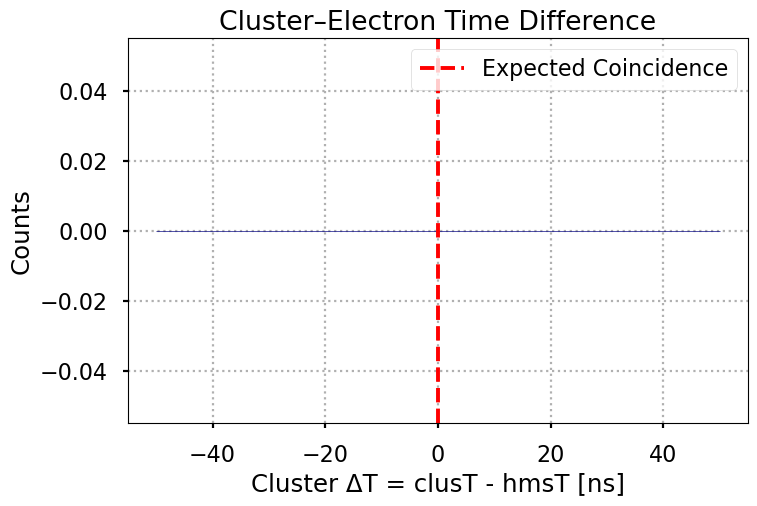

In [ ]:
deltaT_flat = ak.to_numpy(ak.flatten(deltaT))
plt.figure(figsize=(8,5))
plt.hist(deltaT_flat, bins=10, range=(-50, 50), histtype='step', color='navy')
plt.xlabel("Cluster ΔT = clusT - hmsT [ns]")
plt.ylabel("Counts")
plt.title("Cluster–Electron Time Difference")
plt.grid(True, linestyle=":")
plt.axvline(0, color="red", linestyle="--", label="Expected Coincidence")
plt.legend()
plt.show()

# Opening Angle Calculation

The neutral pion decays via:

$$
\pi^0 \to \gamma\gamma
$$

Using four-momentum conservation:

$$
P_\pi^2 = (P_{\gamma_1} + P_{\gamma_2})^2
$$

Expanding the right-hand side:

$$
m_\pi^2 = P_{\gamma_1}^2 + P_{\gamma_2}^2 + 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Since photons are massless, $ P_{\gamma_i}^2 = 0 $, so:

$$
m_\pi^2 = 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Using the inner product of four-vectors:

$$
m_\pi^2 = 2 \left( E_{\gamma_1}E_{\gamma_2} - \vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} \right)
$$

The dot product can be written in terms of the opening angle $\theta$ between the two photons:

$$
\vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} = |\vec{p}_{\gamma_1}||\vec{p}_{\gamma_2}|\cos\theta
$$

Since $ |\vec{p}_{\gamma_i}| = E_{\gamma_i} $ for photons:

$$
m_\pi^2 = 2E_{\gamma_1}E_{\gamma_2}(1 - \cos\theta)
$$

Using the identity $( 1 - \cos\theta = 2\sin^2(\theta/2) )$, we get:

$$
m_\pi^2 = 4E_{\gamma_1}E_{\gamma_2} \sin^2(\theta/2)
$$

Solving for the opening angle $\theta$:

$$
\theta = 2 \sin^{-1}\left( \frac{m_\pi}{\sqrt{4E_{\gamma_1}E_{\gamma_2}}} \right)
$$

This relation can be used as a **kinematic constraint** to validate whether a photon pair is consistent with originating from a real $ \pi^0 $ decay.


In [3]:
# function to reconcstruct invariant neutral pion mass taking into account the opening angle

import numba as nb
import numpy as np
from tqdm import tqdm

M_PION0  = 0.135  # GeV

@nb.njit
def reconstruct_pi0_mass_fast_w_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2

    # Opening angle cut
    theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    theta_tolerance_rad = 0.01 # considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        m2 = total_E**2 - np.dot(total_p, total_p)
        return np.sqrt(m2) if m2 > 0 else 0.0
    else:
        return 0.0  # Or np.nan if you prefer masking out

In [4]:
# masses = []
# for event in branches:  # loop over awkward array
#     e = np.asarray(event["NPS.cal.clusE"])
#     x = np.asarray(event["NPS.cal.clusX"])
#     y = np.asarray(event["NPS.cal.clusY"])
#     if len(e) < 2:
#         continue
#     idx = np.argsort(e)[-2:]
#     masses.append(reconstruct_pi0_mass_fast_w_opening_angle(e[idx[0]], e[idx[1]],
#                                             x[idx[0]], y[idx[0]],
#                                             x[idx[1]], y[idx[1]]))
    
from tqdm import tqdm

masses = []
for event in tqdm(branches, desc="Processing events"):
    e = np.asarray(event["NPS.cal.clusE"])
    x = np.asarray(event["NPS.cal.clusX"])
    y = np.asarray(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast_w_opening_angle(
        e[idx[0]], e[idx[1]],
        x[idx[0]], y[idx[0]],
        x[idx[1]], y[idx[1]]
    ))


Processing events:   0%|          | 0/3222394 [00:00<?, ?it/s]

Processing events: 100%|██████████| 3222394/3222394 [09:19<00:00, 5758.56it/s] 


<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_37463/1249607620.py:4: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_37463/1249607620.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")


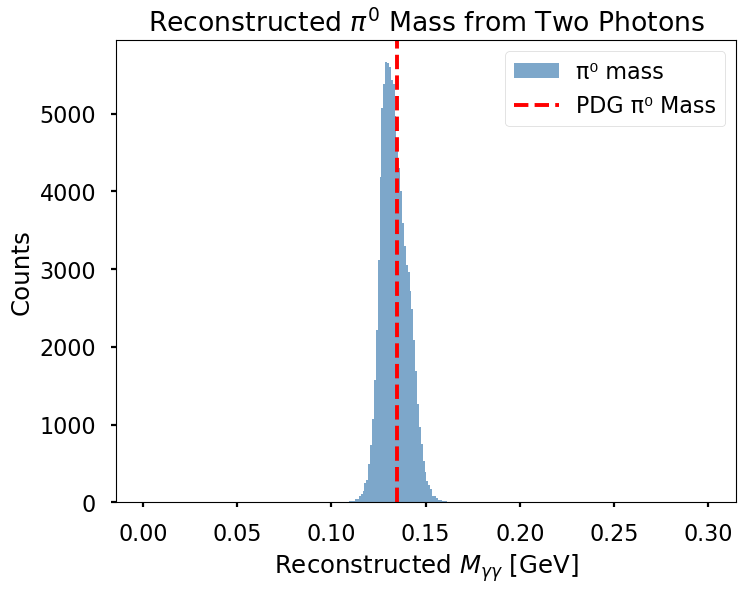

In [11]:
plt.figure(figsize=(8,6))
plt.hist(masses, bins=300, range=(0.001, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_37463/3157529585.py:21: SyntaxWarning: invalid escape sequence '\p'
  density=True, color="steelblue", alpha=0.6, label="Reconstructed $\pi^0$ Mass"
/tmp/ipykernel_37463/3157529585.py:30: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')
/tmp/ipykernel_37463/3157529585.py:33: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
/tmp/ipykernel_37463/3157529585.py:36: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconst

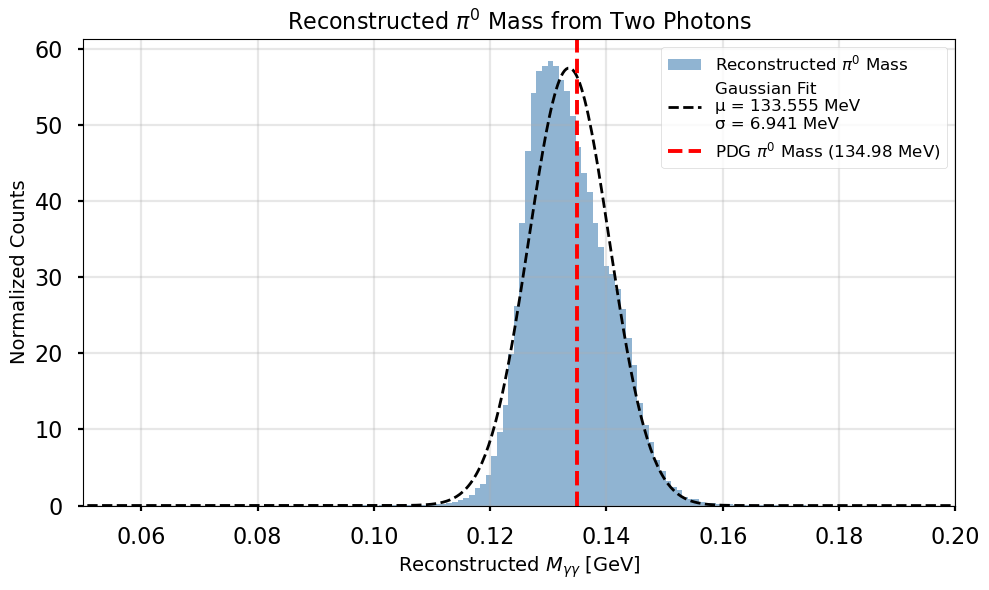

Fitted Mean: 0.1336 GeV
Fitted Std Dev: 0.0069 GeV


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

df_invariant_pi0 = pd.DataFrame(masses)

df_invariant_pi0.to_csv("invariant_mass_pi0_w_opening_angle.csv", mode = 'w', index=False)

# Assuming `masses` is your array of reconstructed π⁰ masses
masses_clean = np.array(masses)
masses_clean = masses_clean[(masses_clean > 0.01) & (masses_clean < 0.3)]

# Fit a Gaussian
mu, std = norm.fit(masses_clean)

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(
    masses_clean, bins=300, range=(0.01, 0.3), 
    density=True, color="steelblue", alpha=0.6, label="Reconstructed $\pi^0$ Mass"
)

# Plot Gaussian fit
x = np.linspace(0.01, 0.3, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label=f'Gaussian Fit\nμ = {1000*mu:.3f} MeV\nσ = {1000*std:.3f} MeV')

# PDG mass line
plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')

# Labels and legend
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.xlim(0.05, 0.2)
plt.ylabel("Normalized Counts", fontsize=14)
plt.title("Reconstructed $\pi^0$ Mass from Two Photons", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Fitted Mean: {mu:.4f} GeV")
print(f"Fitted Std Dev: {std:.4f} GeV")


In [10]:
import numba as nb
import numpy as np

M_PION0 = 0.13498  # GeV

@nb.njit(parallel=True)
def reconstruct_pi0_mass_batch(e1, e2, x1, y1, x2, y2, z_nps=407.0):
    """
    Computes pi0 mass for arrays of photon energies and positions,
    returning mass, theta_data, and theta_ideal for each event.
    
    Parameters
    ----------
    e1, e2 : float arrays
        Energies of the two photons [GeV]
    x1, y1, x2, y2 : float arrays
        Cluster positions in NPS plane [cm]
    z_nps : float
        Distance to NPS [cm]
    
    Returns
    -------
    masses, theta_data, theta_ideal : float arrays
    """



    n = len(e1)
    masses_all_arr = np.zeros(n)
    masses_w_opening_angle_arr = np.zeros(n)
    theta_data_arr = np.zeros(n)
    theta_ideal_arr = np.zeros(n)

    for i in nb.prange(n):
        # --- Norms ---
        norm1 = np.sqrt(x1[i]**2 + y1[i]**2 + z_nps**2)
        norm2 = np.sqrt(x2[i]**2 + y2[i]**2 + z_nps**2)

        # --- Unit vectors ---
        u1x, u1y, u1z = x1[i]/norm1, y1[i]/norm1, z_nps/norm1
        u2x, u2y, u2z = x2[i]/norm2, y2[i]/norm2, z_nps/norm2

        # --- 3-momentum vectors ---
        p1x, p1y, p1z = e1[i]*u1x, e1[i]*u1y, e1[i]*u1z
        p2x, p2y, p2z = e2[i]*u2x, e2[i]*u2y, e2[i]*u2z

        total_E = e1[i] + e2[i]
        total_px = p1x + p2x
        total_py = p1y + p2y
        total_pz = p1z + p2z

        # --- Opening angles ---
        dot = u1x*u2x + u1y*u2y + u1z*u2z
        dot = min(1.0, max(-1.0, dot))  # Clamp for numerical stability
        theta_data = np.arccos(dot)
        theta_ideal = 2.0 * np.arcsin(M_PION0 / np.sqrt(4.0 * e1[i] * e2[i]))

        theta_data_arr[i] = theta_data
        theta_ideal_arr[i] = theta_ideal

        m2 = total_E**2 - (total_px**2 + total_py**2 + total_pz**2)

        masses_all_arr[i] = np.sqrt(m2) if m2 > 0.0 else 0.0

        # --- Mass only if within tolerance ---
        theta_tolerance_rad = 0.015
        if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:
            masses_w_opening_angle_arr[i] = np.sqrt(m2) if m2 > 0.0 else 0.0
        else:
            masses_w_opening_angle_arr[i] = 0.0  # or np.nan

    return masses_all_arr, masses_w_opening_angle_arr, theta_data_arr, theta_ideal_arr


Saved pi0_mass_theta_data.csv
Selected 79613 events with ≥2 clusters E>1.2 GeV
Selected 34415 events with |Δθ| ≤ 0.02 rad
Ratio of within opening angle to all:  0.432


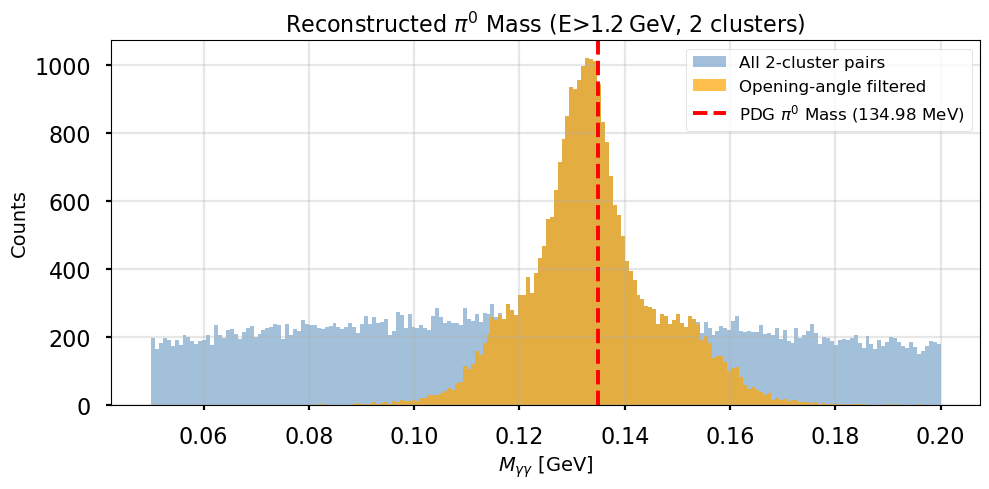

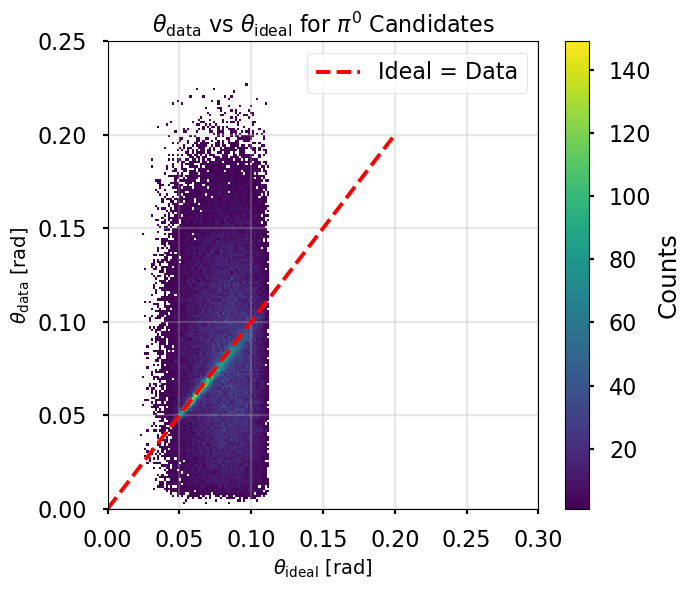

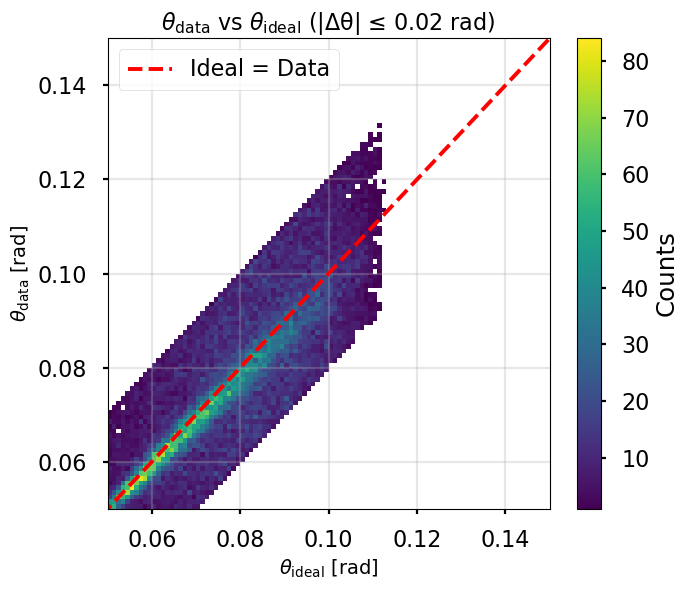

In [17]:
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]
clusX = branches["NPS.cal.clusX"]
clusY = branches["NPS.cal.clusY"]

# --- Correct Mask ---
energy_cut = 1.2
mask_energy = clusE > energy_cut                     # per-cluster mask
clusE_masked = clusE[mask_energy]
clusT_masked = clusT[mask_energy]
clusX_masked = clusX[mask_energy]
clusY_masked = clusY[mask_energy]

# --- Keep only events with >=2 clusters ---
mask_2plus = ak.num(clusE_masked) >= 2
clusE_sel = clusE_masked[mask_2plus]
clusT_sel = clusT_masked[mask_2plus]
clusX_sel = clusX_masked[mask_2plus]
clusY_sel = clusY_masked[mask_2plus]

# --- Now it's safe to index [:,0] and [:,1] ---
e1 = ak.to_numpy(clusE_sel[:, 0])
e2 = ak.to_numpy(clusE_sel[:, 1])
x1 = ak.to_numpy(clusX_sel[:, 0])
y1 = ak.to_numpy(clusY_sel[:, 0])
x2 = ak.to_numpy(clusX_sel[:, 1])
y2 = ak.to_numpy(clusY_sel[:, 1])

# --- Reconstruct π⁰ masses and angles ---
masses_all, masses_w_opening_angle, theta_data, theta_ideal = reconstruct_pi0_mass_batch(e1, e2, x1, y1, x2, y2)

# --- Save CSVs ---
pd.DataFrame({"mass_all": masses_all, "mass_w_opening_angle": masses_w_opening_angle, "theta_data": theta_data, "theta_ideal": theta_ideal}) \
    .to_csv("pi0_mass_theta_data.csv", index=False)

print("Saved pi0_mass_theta_data.csv")

# --- Filter valid masses for plotting ---
valid = masses_all > 0
# masses_all_nonzero = masses_all[valid]
theta_data_nonzero = theta_data[valid]
theta_ideal_nonzero = theta_ideal[valid]

# --- Filter valid events ---
valid_all = masses_all > 0
valid_opening = masses_w_opening_angle > 0

masses_all_nonzero = masses_all[valid_all]
masses_opening_nonzero = masses_w_opening_angle[valid_opening]

# --- Apply tight opening angle cut ---
mask_angle = np.abs(theta_data_nonzero - theta_ideal_nonzero) <= 0.02

theta_data_tight = theta_data_nonzero[mask_angle]
theta_ideal_tight = theta_ideal_nonzero[mask_angle]

print(f"Selected {len(clusE_sel)} events with ≥2 clusters E>{energy_cut} GeV")
print(f"Selected {len(theta_data_tight)} events with |Δθ| ≤ 0.02 rad\nRatio of within opening angle to all: {len(theta_data_tight)/len(clusE_sel): .3f}")

# --- 1. Mass Histogram Comparison ---
plt.figure(figsize=(10, 5))

# Histogram for all pairs
plt.hist(
    masses_all_nonzero, bins=200, range=(0.05, 0.2),
    color="steelblue", alpha=0.5, label="All 2-cluster pairs"
)

# Histogram for opening-angle-filtered pairs
plt.hist(
    masses_opening_nonzero, bins=200, range=(0.05, 0.2),
    color="orange", alpha=0.7, label=r"Opening-angle filtered"
)

# PDG π⁰ line
plt.axvline(0.13498, color='red', linestyle='--', label=r'PDG $\pi^0$ Mass (134.98 MeV)')

# Labels
plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title(fr"Reconstructed $\pi^0$ Mass (E>{energy_cut} GeV, 2 clusters)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("pi0_mass_hist_comparison.png", dpi=150)
plt.show()


# # --- 1. Mass Histogram ---
# plt.figure(figsize=(10, 5))
# plt.hist(masses_all_nonzero, bins=200, range=(0.05, 0.2),
#          color="steelblue", alpha=0.7)
# plt.axvline(0.13498, color='red', linestyle='--', label=r'PDG $\pi^0$ Mass (134.98 MeV)')
# plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]", fontsize=14)
# plt.ylabel("Counts", fontsize=14)
# plt.title(r"Reconstructed $\pi^0$ Mass (E>0.5 GeV, 2 clusters)", fontsize=16)
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# # plt.savefig("pi0_mass_hist.png", dpi=150)
# plt.show()



# --- 2. 2D θ Data vs θ Ideal ---
plt.figure(figsize=(7, 6))
plt.hist2d(theta_ideal_nonzero, theta_data_nonzero,
           bins=200, range=[[0, 0.30], [0, 0.25]], cmap='viridis', cmin=1)
plt.colorbar(label='Counts')
plt.plot([0, 0.2], [0, 0.2], 'r--', label='Ideal = Data')
plt.xlabel(r"$\theta_{\mathrm{ideal}}$ [rad]", fontsize=14)
plt.ylabel(r"$\theta_{\mathrm{data}}$ [rad]", fontsize=14)
plt.title(r"$\theta_{\mathrm{data}}$ vs $\theta_{\mathrm{ideal}}$ for $\pi^0$ Candidates", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("theta_data_vs_ideal.png", dpi=150)
plt.show()


# --- 2D θ Data vs θ Ideal ---
plt.figure(figsize=(7, 6))
plt.hist2d(theta_ideal_tight, theta_data_tight,
           bins=100, range=[[0.05, 0.15], [0.05, 0.15]], cmap='viridis', cmin=1)
plt.colorbar(label='Counts')

# Diagonal line
plt.plot([0, 0.2], [0, 0.2], 'r--', label=r'Ideal = Data')

# Labels and style
plt.xlabel(r"$\theta_{\mathrm{ideal}}$ [rad]", fontsize=14)
plt.ylabel(r"$\theta_{\mathrm{data}}$ [rad]", fontsize=14)
plt.title(r"$\theta_{\mathrm{data}}$ vs $\theta_{\mathrm{ideal}}$ (|Δθ| ≤ 0.02 rad)", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("theta_data_vs_ideal_tight.png", dpi=150)
plt.show()



Computed corrected masses for 109853 nonzero π⁰ candidates.


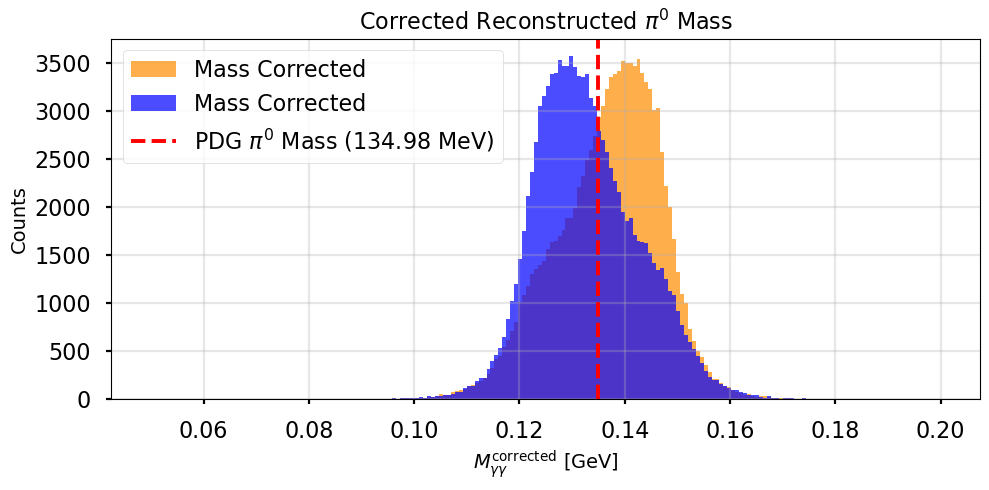

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSV ---
df_temp = pd.read_csv('pi0_mass_theta_data.csv')

# --- Compute corrected mass for all rows ---
theta_data = df_temp["theta_data"].to_numpy()
theta_ideal = df_temp["theta_ideal"].to_numpy()
masses_w_opening_angle = df_temp["mass_w_opening_angle"].to_numpy()

# Compute cot(theta_data/2)
cot_half_theta = np.cos(theta_data/2) / np.sin(theta_data/2)

# Mass correction
mass_corrected = masses_w_opening_angle + masses_w_opening_angle * cot_half_theta * (theta_ideal - theta_data)

# Add to DataFrame
df_temp["mass_corrected"] = mass_corrected

# --- Filter valid masses for plotting ---
mass_corrected_nonzero = mass_corrected[mass_corrected > 0]


print(f"Computed corrected masses for {len(mass_corrected_nonzero)} nonzero π⁰ candidates.")

# --- Plot histogram ---
plt.figure(figsize=(10, 5))
plt.hist(mass_corrected_nonzero, bins=200, range=(0.05, 0.2),
         color="darkorange", alpha=0.7, label="Mass Corrected")
plt.hist(masses_w_opening_angle, bins=200, range=(0.05, 0.2),
         color="blue", alpha=0.7, label="Mass Corrected")
plt.axvline(0.13498, color='red', linestyle='--', label=r'PDG $\pi^0$ Mass (134.98 MeV)')
plt.xlabel(r"$M_{\gamma\gamma}^{\mathrm{corrected}}$ [GeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title(r"Corrected Reconstructed $\pi^0$ Mass", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


     mass_all  mass_w_opening_angle  theta_data  theta_ideal  mass_corrected
1    0.129136              0.129136    0.083209     0.086977        0.140825
4    0.152842              0.152842    0.108447     0.095763        0.152842
14   0.140045              0.140045    0.080843     0.077918        0.140045
28   0.139836              0.139836    0.137516     0.132734        0.139836
33   0.127166              0.127166    0.109999     0.116766        0.142795
36   0.135733              0.135733    0.064593     0.064235        0.135733
51   0.130315              0.130315    0.102797     0.106480        0.139646
56   0.122226              0.122226    0.140539     0.155232        0.147741
57   0.135948              0.135948    0.135394     0.134429        0.135948
64   0.125148              0.125148    0.114853     0.123888        0.144815
73   0.140832              0.140832    0.087491     0.083853        0.140832
77   0.145826              0.145826    0.132160     0.122317        0.145826

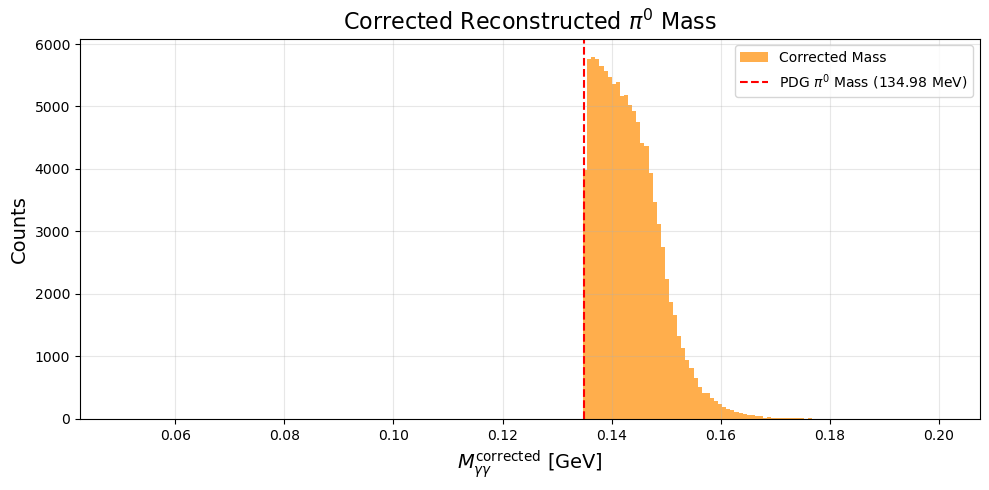

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
df_temp = pd.read_csv('pi0_mass_theta_data.csv')

# Filter rows where mass_w_opening_angle > 0
df_nonzero = df_temp[df_temp["mass_w_opening_angle"] > 0].copy()

# --- Compute mass correction ---
theta_data = df_nonzero["theta_data"].to_numpy()
theta_ideal = df_nonzero["theta_ideal"].to_numpy()
masses_w_opening_angle = df_nonzero["mass_w_opening_angle"].to_numpy()

# Compute corrected mass element-wise
cot_half_theta = np.cos(theta_data/2) / np.sin(theta_data/2)
delta_theta = theta_ideal - theta_data

mass_corrected = np.where(
    delta_theta > 0,
    masses_w_opening_angle + masses_w_opening_angle * cot_half_theta * delta_theta,
    masses_w_opening_angle
)

# Add to DataFrame
df_nonzero["mass_corrected"] = mass_corrected

print(df_nonzero.head(20))

# --- Plot histogram of corrected mass ---
plt.figure(figsize=(10, 5))
plt.hist(mass_corrected, bins=200, range=(0.05, 0.2),
         color="darkorange", alpha=0.7, label="Corrected Mass")
plt.axvline(0.13498, color='red', linestyle='--', label=r'PDG $\pi^0$ Mass (134.98 MeV)')
plt.xlabel(r"$M_{\gamma\gamma}^{\mathrm{corrected}}$ [GeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title(r"Corrected Reconstructed $\pi^0$ Mass", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
print("mass_corrected min, max, mean:", mass_corrected.min(), mass_corrected.max(), mass_corrected.mean())
print("Number of values < PDG mass:", np.sum(mass_corrected < 0.13498))
print("Number of values >= PDG mass:", np.sum(mass_corrected >= 0.13498))
print("Number of values all:", np.sum(masses_w_opening_angle > 0))


mass_corrected min, max, mean: 0.1349800324427927 0.1956453274440416 0.14320775692794255
Number of values < PDG mass: 0
Number of values >= PDG mass: 109853
Number of values all: 109853


length of missing mass pr: 12625
lenght of invariant mass pi0: 887102


/tmp/ipykernel_1384/3841821425.py:11: RuntimeWarning: invalid value encountered in sqrt
  miss_pr_mass = np.sqrt(miss_pr_mass_sq)


ValueError: x and y must have the same length.

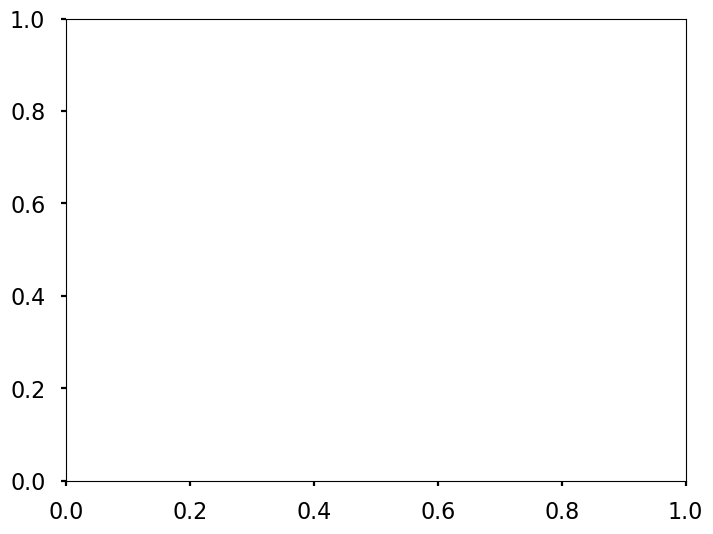

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSVs ---
df_missing_pr_mass = pd.read_csv('missing_mass_sq_w_openging_angle.csv')
df_invariant_pi0_mass = pd.read_csv('pi0_mass_theta_data.csv')

# --- Extract data ---
miss_pr_mass_sq = df_missing_pr_mass["0"].to_numpy()
miss_pr_mass = np.sqrt(miss_pr_mass_sq)

invariant_pi0_mass = df_invariant_pi0_mass["mass_w_opening_angle"].to_numpy()

print(f'length of missing mass pr: {len(miss_pr_mass)}')
print(f'lenght of invariant mass pi0: {len(invariant_pi0_mass)}')

# --- Filter valid events ---
# valid_mask = (miss_pr_mass > 0) & (invariant_pi0_mass > 0)
# miss_pr_mass = miss_pr_mass[valid_mask]
# invariant_pi0_mass = invariant_pi0_mass[valid_mask]

# --- 2D Histogram ---
plt.figure(figsize=(8, 6))
plt.hist2d(
    invariant_pi0_mass, miss_pr_mass,
    bins=[200, 200],
    range=[[0.05, 0.2], [0.5, 1.2]],  # adjust y-range to your data
    cmap='plasma',
    cmin=1
)
plt.colorbar(label='Counts')

# Labels and Title
plt.xlabel(r"Invariant $\pi^0$ Mass [GeV]", fontsize=14)
plt.ylabel(r"Missing Proton Mass [GeV]", fontsize=14)
plt.title(r"$M_{\gamma\gamma}$ vs Missing Proton Mass", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Include Josh's good cluster cuts

# Background subtraction tests

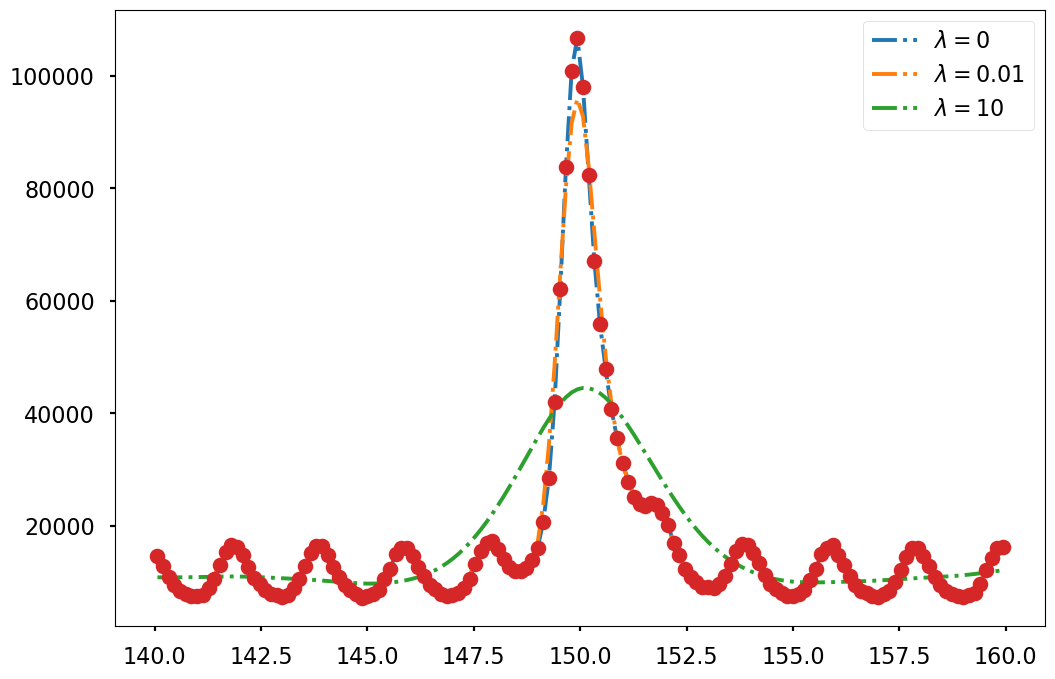

In [ ]:
import numpy as np
from scipy.interpolate import make_smoothing_spline
import matplotlib.pyplot as plt

clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
hist_signal,bin_edges = np.histogram(clusT, bins=150, range=(140,160))
# === Bin centers ===
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(12,8))
for lam in [0, 0.01, 10]:
    spl = make_smoothing_spline(bin_centers, hist_signal, lam=lam)
    plt.plot(bin_centers, spl(bin_centers), '-.', label=fr'$\lambda=${lam}')
plt.plot(bin_centers, hist_signal, 'o')
plt.legend()    
plt.show()

In [38]:
import numpy as np
from scipy.interpolate import make_splprep
import matplotlib.pyplot as plt

clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
hist_signal,bin_edges = np.histogram(clusT, bins=150, range=(140,160))
# === Bin centers ===
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(12,8))
plt.plot(bin_centers, make_splprep(bin_centers, hist_signal, s=0)(bin_centers), '-', label='s=0')
plt.plot(bin_centers, hist_signal, 'o')
plt.legend()
plt.show()

TypeError: make_splprep() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 1200x800 with 0 Axes>

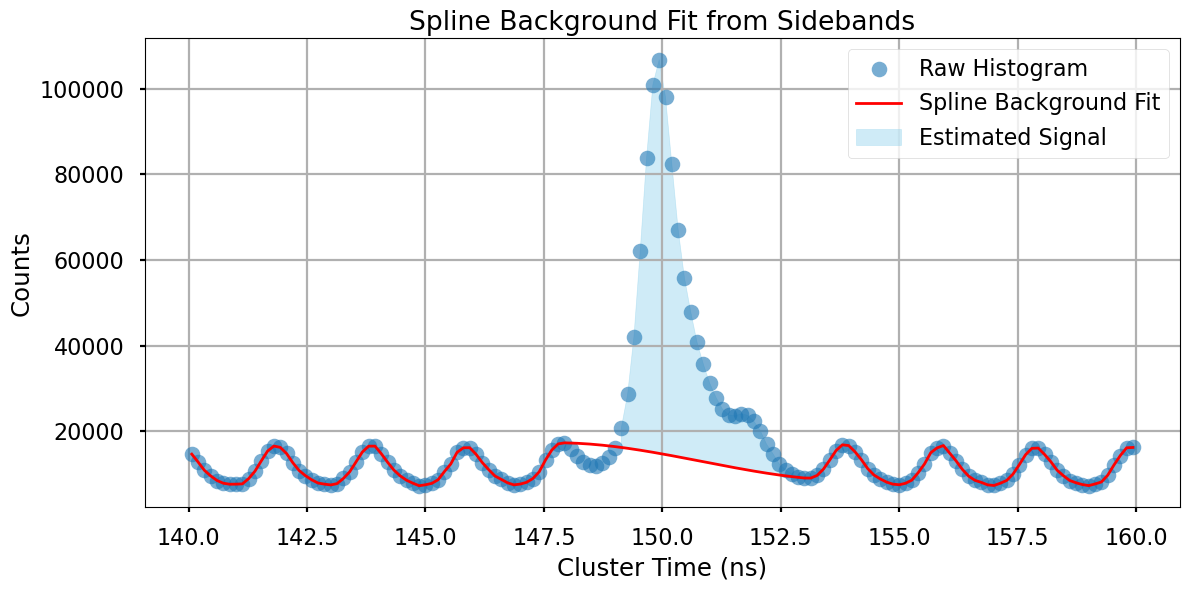

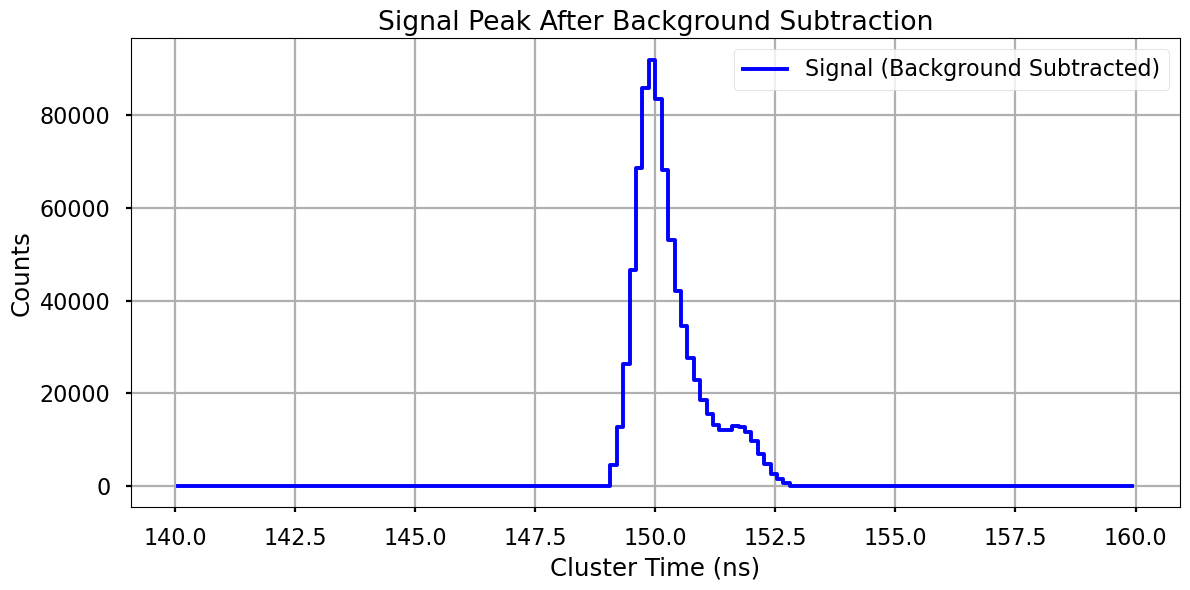

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import awkward as ak

# === Load data and histogram ===
clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
hist_signal, bin_edges = np.histogram(clusT, bins=150, range=(140, 160))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# === Define sidebands ===
sideband_mask = ((bin_centers >= 140) & (bin_centers <= 148)) | ((bin_centers >= 153) & (bin_centers <= 160))
x_sideband = bin_centers[sideband_mask]
y_sideband = hist_signal[sideband_mask]

# === Fit spline to sidebands ===
spline_fit = UnivariateSpline(x_sideband, y_sideband, s=2)  # Adjust s as needed for smoothing

# === Predict full background ===
background_estimate = spline_fit(bin_centers)

# === Subtract background ===
signal_subtracted = hist_signal - background_estimate
signal_subtracted[signal_subtracted < 0] = 0  # Avoid negatives

# === Plot: Raw + Fit ===
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_signal, 'o', label='Raw Histogram', alpha=0.6)
plt.plot(bin_centers, background_estimate, '-', label='Spline Background Fit', color='red', linewidth=2)
plt.fill_between(bin_centers, background_estimate, hist_signal, where=(hist_signal > background_estimate), 
                 color='skyblue', alpha=0.4, label='Estimated Signal')
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title("Spline Background Fit from Sidebands")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot: Background Subtracted Signal ===
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, signal_subtracted, drawstyle='steps-mid', color='blue', label='Signal (Background Subtracted)')
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title("Signal Peak After Background Subtraction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


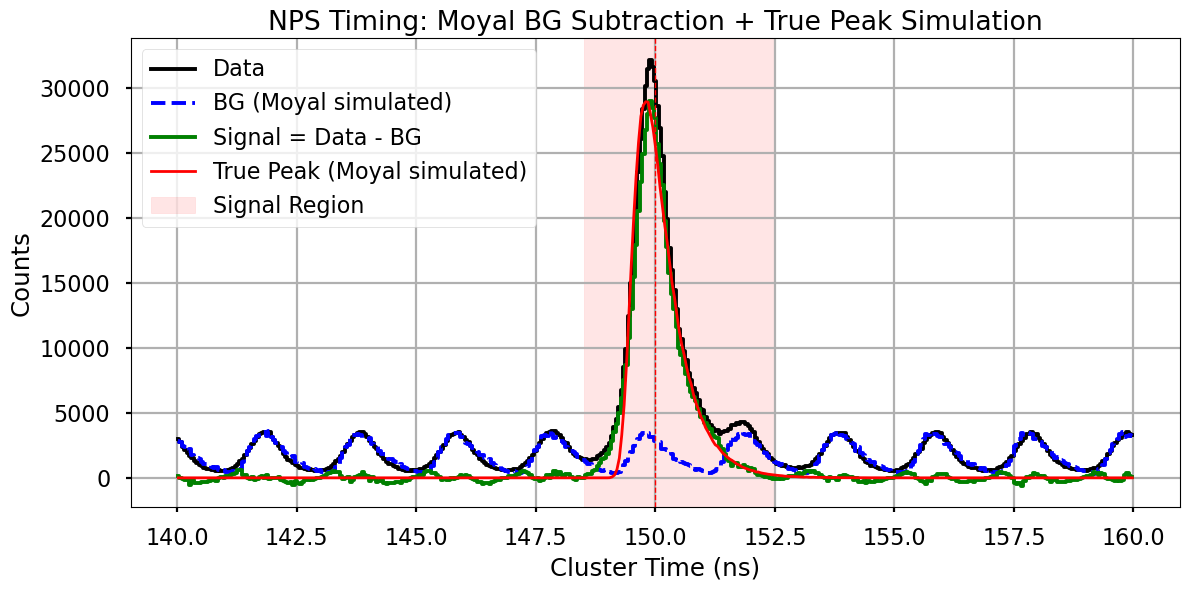

Scale factor for background: 4.269
Scale factor for simulated true peak: 0.598


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal
from scipy.stats import landau
import awkward as ak

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply mask per cluster, preserving jagged structure
mask = clusE > 0.5

# Apply mask before flattening
clusT_selected = clusT[mask]

# Flatten to 1D array for histogramming
clusT_flat = ak.to_numpy(ak.flatten(clusT_selected))


# === Load real data ===
# clusT = ak.to_numpy(ak.flatten(branches["NPS.cal.clusT"]))
clusT = clusT_flat

# === Parameters ===
beam_bucket_spacing = 2.0        # ns
n_buckets = 200                  # +/- 400 ns window
true_peak_time = 150.0           # ns
timing_resolution = 0.25          # ns
n_true_events = 1000000
n_bg_per_bucket = 16000
# time_offset = 0.1 # 
time_offset = 0.2 # Moyal

# === Histogram bins ===
bins = np.linspace(140, 160, 400)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# === Simulate Background using Moyal ===
bg_times = []
for i in range(-n_buckets, n_buckets + 1):
    t_bucket = true_peak_time + i * beam_bucket_spacing
    bg_cluster_times = moyal.rvs(loc=t_bucket - time_offset, scale=timing_resolution, size=n_bg_per_bucket)
    bg_times.extend(bg_cluster_times)

bg_times = np.array(bg_times)

# === Histogram data and background ===
hist_data, _ = np.histogram(clusT, bins=bins)
hist_bg, _ = np.histogram(bg_times, bins=bins)

# === Background normalization using sidebands ===
sideband_mask = ((bin_centers < 148.5) | (bin_centers > 152.5))
data_sb_sum = np.sum(hist_data[sideband_mask])
sim_sb_sum = np.sum(hist_bg[sideband_mask])
scale_factor_bg = data_sb_sum / sim_sb_sum if sim_sb_sum > 0 else 0
scaled_bg = hist_bg * scale_factor_bg

# === Background-subtracted signal ===
subtracted = hist_data - scaled_bg

# === Simulate true signal using Moyal ===
true_signal_sim_samples = moyal.rvs(loc=true_peak_time - time_offset, scale=timing_resolution, size=n_true_events)
hist_true_signal_sim, _ = np.histogram(true_signal_sim_samples, bins=bins)
# hist_true_signal_sim = hist_true_signal_sim / np.sum(hist_true_signal_sim)  # Normalize

# === Normalize true peak to match signal region area ===
signal_region_mask = ((bin_centers > 148.5) & (bin_centers < 152.5))
area_data_signal = np.sum(subtracted[signal_region_mask])
area_true_sim = np.sum(hist_true_signal_sim[signal_region_mask])
scale_factor_signal = area_data_signal / area_true_sim if area_true_sim > 0 else 0
scaled_true_signal = hist_true_signal_sim * scale_factor_signal

# === Plot ===
plt.figure(figsize=(12, 6))
plt.step(bin_centers, hist_data, where='mid', color='black', label='Data')
plt.step(bin_centers, scaled_bg, where='mid', color='blue', linestyle='--', label='BG (Moyal simulated)')
plt.step(bin_centers, subtracted, where='mid', color='green', label='Signal = Data - BG')
plt.plot(bin_centers, scaled_true_signal, color='red', lw=2, label='True Peak (Moyal simulated)')
plt.axvspan(148.5, 152.5, color='red', alpha=0.1, label='Signal Region')
plt.axvline(true_peak_time, color='red', linestyle='--', linewidth=1)
plt.xlabel("Cluster Time (ns)")
plt.ylabel("Counts")
plt.title("NPS Timing: Moyal BG Subtraction + True Peak Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Scale factor for background: {scale_factor_bg:.3f}")
print(f"Scale factor for simulated true peak: {scale_factor_signal:.3f}")


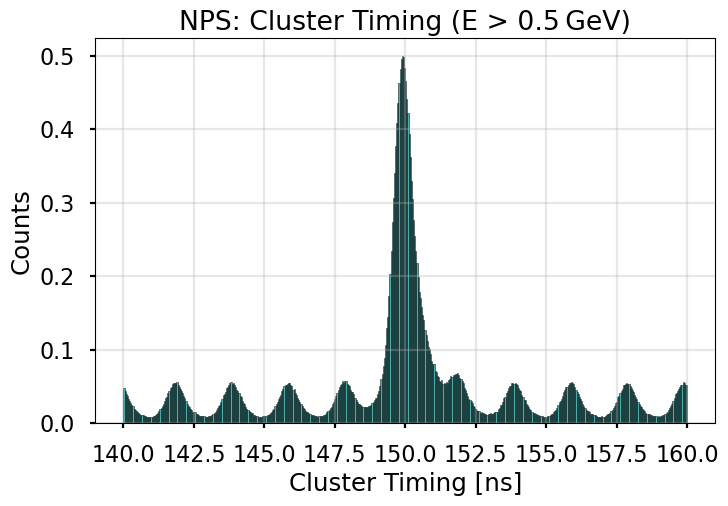

In [44]:
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply mask per cluster, preserving jagged structure
mask = clusE > 0.5

# Apply mask before flattening
clusT_selected = clusT[mask]

# Flatten to 1D array for histogramming
clusT_flat = ak.to_numpy(ak.flatten(clusT_selected))

plt.figure(figsize=(8,5))
plt.hist(clusT_flat, bins=500, range=(140,160), density=True,
         color="darkcyan", edgecolor="black", alpha=0.7)
plt.xlabel("Cluster Timing [ns]")
plt.ylabel("Counts")
plt.title("NPS: Cluster Timing (E > 0.5 GeV)")
plt.grid(True, alpha=0.3)
plt.show()

Generated 887102 2-cluster pairs.


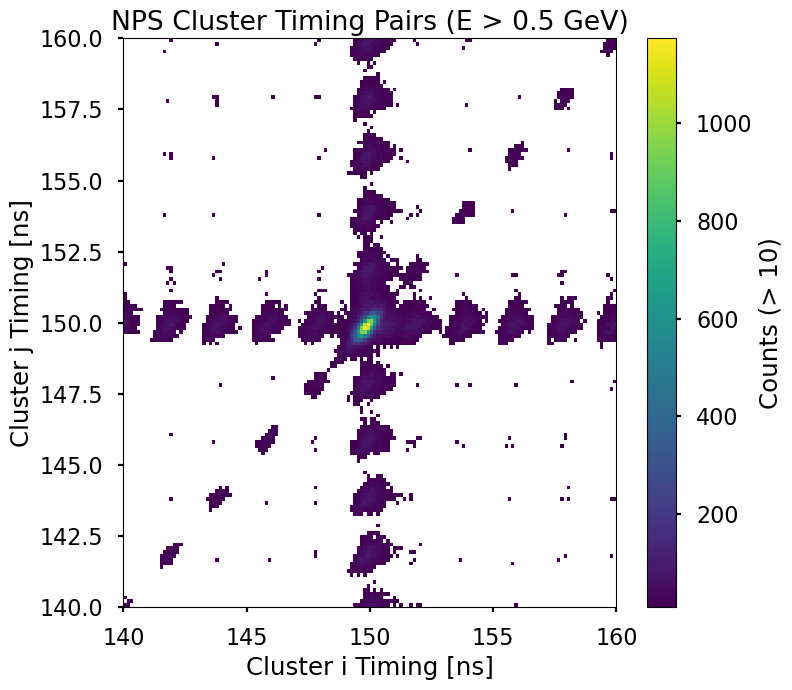

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# Apply cluster energy cut
mask = clusE > 0.5
clusT_selected = clusT[mask]

# Keep only events with at least 2 clusters after masking
mask_two_clusters = ak.num(clusT_selected) >= 2
clusT_two = clusT_selected[mask_two_clusters]

# Extract first and second cluster times
clusT0 = ak.to_numpy(clusT_two[:, 0])
clusT1 = ak.to_numpy(clusT_two[:, 1])

# print(f"Generated {len(clusT0)} 2-cluster pairs.")

# # --- 2D Histogram ---
# plt.figure(figsize=(8, 7))
# hist = plt.hist2d(clusT0, clusT1, bins=[150, 150], range=[[145, 155], [145, 155]], 
#                   cmap='viridis', norm=None)

# plt.colorbar(label='Counts')
# plt.xlabel("Cluster 1 Timing [ns]")
# plt.ylabel("Cluster 2 Timing [ns]")
# plt.title("NPS: Cluster 1 vs Cluster 2 Timing (E > 0.5 GeV)")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# === 2D Histogram ===
bins = 150
hist_range = [[140, 160], [140, 160]]
counts, xedges, yedges = np.histogram2d(clusT0, clusT1, bins=bins, range=hist_range)

# === Apply threshold ===
threshold = 10  # Only show bins with counts > threshold
counts_masked = np.where(counts > threshold, counts, np.nan)  # Mask low-count bins

print(f"Generated {len(clusT0)} 2-cluster pairs.")

# === Plot masked 2D histogram ===
plt.figure(figsize=(8,7))
X, Y = np.meshgrid(xedges, yedges)
pcm = plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis')  # Transpose for correct orientation
plt.colorbar(label=f'Counts (> {threshold})')
plt.xlabel("Cluster i Timing [ns]")
plt.ylabel("Cluster j Timing [ns]")
plt.title(f"NPS Cluster Timing Pairs (E > 0.5 GeV)")
plt.grid(False)
plt.tight_layout()
plt.show()


Generated 1818248 2-cluster pairs.


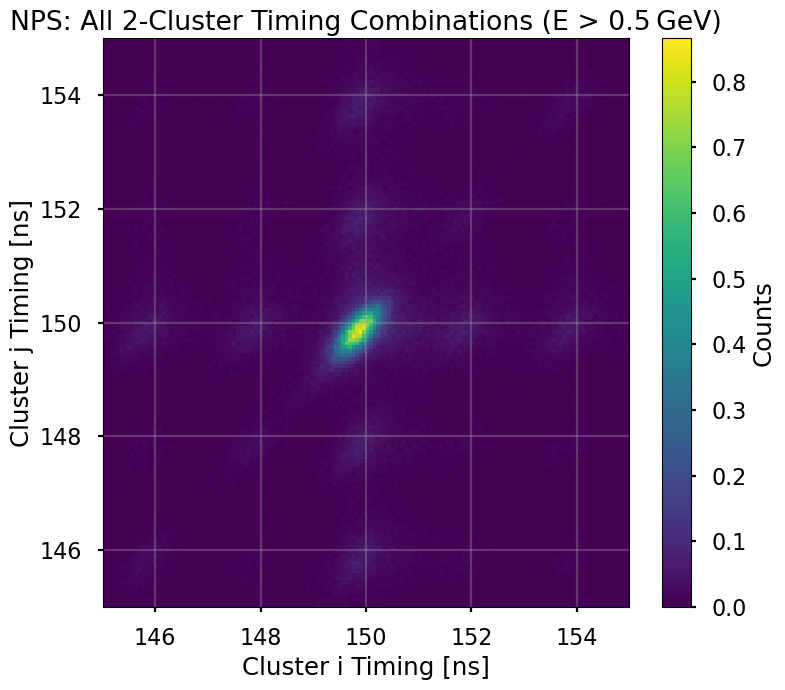

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import itertools

clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# --- Apply cluster energy cut ---
mask = clusE > 0.5
clusT_selected = clusT[mask]

# --- Only consider events with 2+ clusters ---
mask_two_clusters = ak.num(clusT_selected) >= 2
clusT_multi = clusT_selected[mask_two_clusters]

# --- Generate all 2-cluster combinations per event ---
clus_pairs_0 = []
clus_pairs_1 = []

for times in clusT_multi:
    # Generate all unique 2-combinations
    for t0, t1 in itertools.combinations(times, 2):
        clus_pairs_0.append(t0)
        clus_pairs_1.append(t1)

clus_pairs_0 = np.array(clus_pairs_0)
clus_pairs_1 = np.array(clus_pairs_1)

print(f"Generated {len(clus_pairs_0)} 2-cluster pairs.")

# --- 2D Histogram ---
plt.figure(figsize=(8, 7))
plt.hist2d(clus_pairs_0, clus_pairs_1, bins=[150, 150],
           range=[[145, 155], [145, 155]], cmap='viridis', density=0.5)

plt.colorbar(label='Counts')
plt.xlabel("Cluster i Timing [ns]")
plt.ylabel("Cluster j Timing [ns]")
plt.title("NPS: All 2-Cluster Timing Combinations (E > 0.5 GeV)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Generated 1141705 2-cluster pairs.


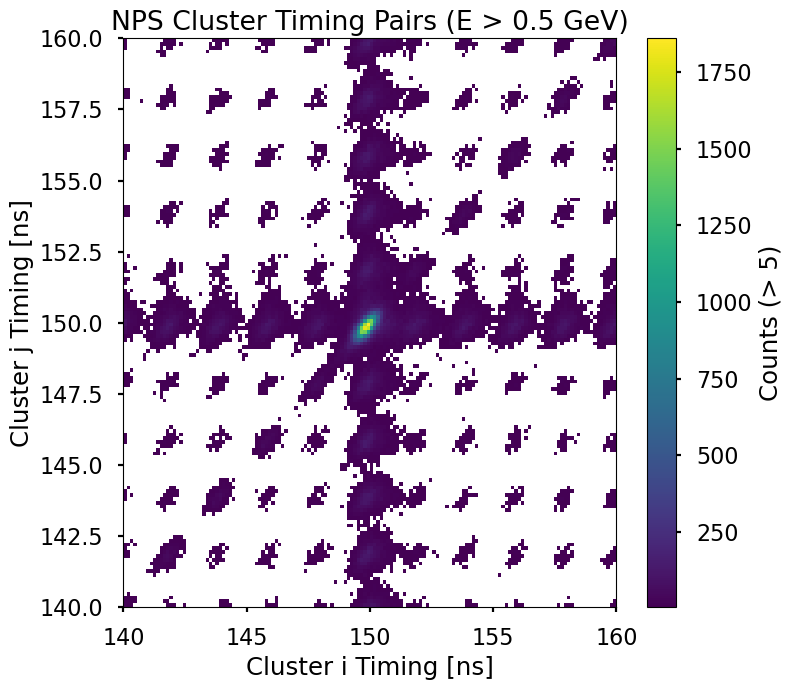

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# === Prepare all cluster pairs from multi-cluster events ===
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

mask = clusE > 0.6
clusT_selected = clusT[mask]

# Generate all possible cluster timing pairs (i,j) for multi-cluster events
clus_pairs = []
for event in ak.to_list(clusT_selected):
    if len(event) > 1:
        for i in range(len(event)):
            for j in range(i+1, len(event)):
                clus_pairs.append((event[i], event[j]))

clus_pairs = np.array(clus_pairs)
clus_pairs_0 = clus_pairs[:, 0]
clus_pairs_1 = clus_pairs[:, 1]

# === 2D Histogram ===
bins = 150
hist_range = [[140, 160], [140, 160]]
counts, xedges, yedges = np.histogram2d(clus_pairs_0, clus_pairs_1, bins=bins, range=hist_range)

# === Apply threshold ===
threshold = 5  # Only show bins with counts > threshold
counts_masked = np.where(counts > threshold, counts, np.nan)  # Mask low-count bins

print(f"Generated {len(clus_pairs_0)} 2-cluster pairs.")

# === Plot masked 2D histogram ===
plt.figure(figsize=(8,7))
X, Y = np.meshgrid(xedges, yedges)
pcm = plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis')  # Transpose for correct orientation
plt.colorbar(label=f'Counts (> {threshold})')
plt.xlabel("Cluster i Timing [ns]")
plt.ylabel("Cluster j Timing [ns]")
plt.title(f"NPS Cluster Timing Pairs (E > 0.5 GeV)")
plt.grid(False)
plt.tight_layout()
plt.show()


Total events in file: 3222394
Events with >=2 clusters passing E>0.5 GeV (per-cluster mask applied): 3222394
Events with >=2 in-time clusters (threefold candidates): 66286
Total pairs to histogram: 73686


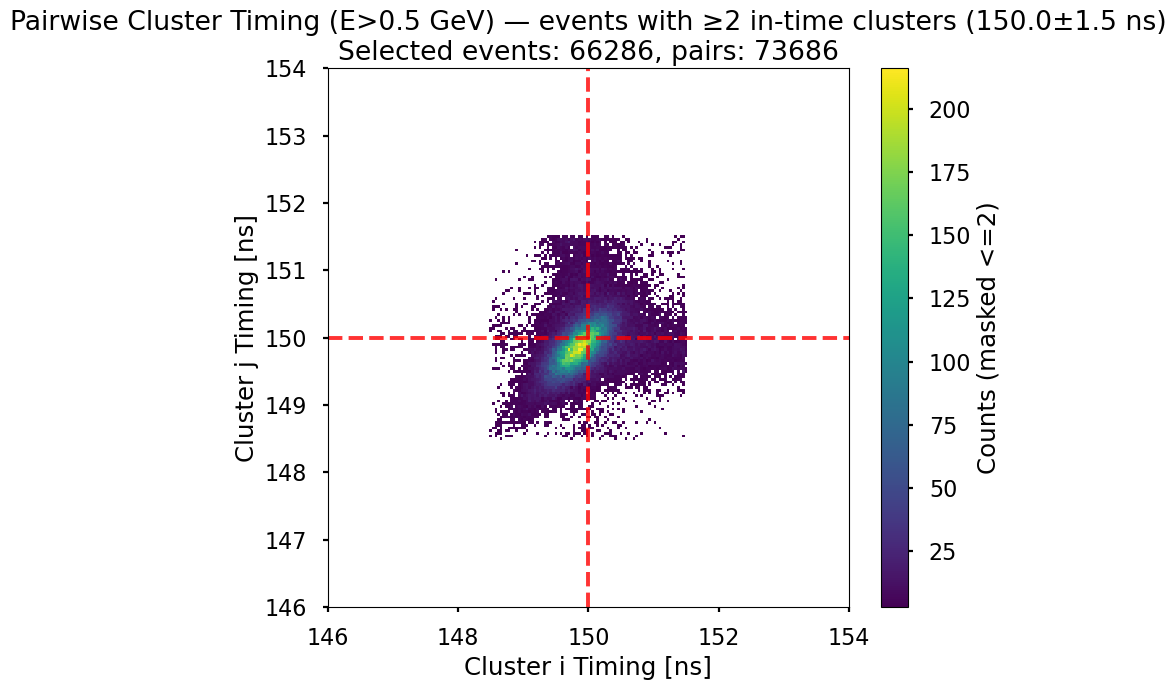

Saved filtered_clusters_threefold_events.csv; total rows = 136187


In [70]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Parameters (tweak)
# ---------------------------
ecut = 0.5                # per-cluster energy cut [GeV]
t0 = 150.0                # electron coincidence time [ns]
twin = 1.5                # coincidence half-width (± twin ns around t0)
max_events_for_plot = None   # set None to use all selected events
threshold = 2             # minimum counts per 2D bin to display (mask low bins)
bins = 200                # number of bins along each axis
downsample_seed = 42

# ---------------------------
# Inputs (assumed available)
# ---------------------------
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]

# ---------------------------
# 1) Per-cluster energy mask (preserve jagged structure)
# ---------------------------
mask_energy = clusE > ecut
clusT_energy_sel = clusT[mask_energy]
clusE_energy_sel = clusE[mask_energy]

# 2) In-time mask per cluster w.r.t t0
in_time = abs(clusT_energy_sel - t0) <= twin

# 3) Events with >=2 in-time clusters (threefold candidates)
n_in_time_per_event = ak.sum(in_time, axis=1)
events_threefold_mask = n_in_time_per_event >= 2

# 4) Keep only those events (structure preserved)
clusT_threefold = clusT_energy_sel[events_threefold_mask]
clusE_threefold = clusE_energy_sel[events_threefold_mask]
in_time_threefold = in_time[events_threefold_mask]

print(f"Total events in file: {len(clusT)}")
print(f"Events with >=2 clusters passing E>{ecut} GeV (per-cluster mask applied): {len(clusT_energy_sel)}")
print(f"Events with >=2 in-time clusters (threefold candidates): {len(clusT_threefold)}")

# 5) Filter each selected event to only its in-time clusters (still jagged)
filtered_clusT = clusT_threefold[in_time_threefold]
filtered_clusE = clusE_threefold[in_time_threefold]

# Quick safety check: do we have any events?
if len(filtered_clusT) == 0:
    raise RuntimeError("No events with >=2 in-time clusters after cuts. Try loosening ecut/twin.")

# 6) Build per-event pairwise combinations using awkward, then unzip
pairs = ak.combinations(filtered_clusT, 2)   # shape: (n_events, n_pairs_per_event, 2) as records
# unzip returns tuple of arrays (firsts, seconds) with same jagged layout
pair0_jag, pair1_jag = ak.unzip(pairs)

# 7) Optionally downsample events for plotting to avoid huge memory
n_events_sel = len(filtered_clusT)
if max_events_for_plot is not None and n_events_sel > max_events_for_plot:
    rng = np.random.default_rng(downsample_seed)
    sel_idx = rng.choice(n_events_sel, size=max_events_for_plot, replace=False)
    sel_pairs = ak.combinations(filtered_clusT[sel_idx], 2)
    pair0_jag, pair1_jag = ak.unzip(sel_pairs)
    print(f"Downsampled to {max_events_for_plot} events for plotting")

# 8) Flatten the jagged pair arrays to 1D numpy arrays for histogramming
pair0 = ak.to_numpy(ak.flatten(pair0_jag))
pair1 = ak.to_numpy(ak.flatten(pair1_jag))

print(f"Total pairs to histogram: {len(pair0)}")

# 9) Build 2D histogram in a sensible window around t0 (you can change)
plot_half_window = 4.0    # ns around t0 to visualize (±4 ns)
hist_range = [[t0 - plot_half_window, t0 + plot_half_window],
              [t0 - plot_half_window, t0 + plot_half_window]]

H, xedges, yedges = np.histogram2d(pair0, pair1, bins=bins, range=hist_range)

# Mask low-count bins for visualization
H_masked = np.where(H > threshold, H, np.nan)

# 10) Plot
plt.figure(figsize=(8, 7))
X, Y = np.meshgrid(xedges, yedges)
pcm = plt.pcolormesh(X, Y, H_masked.T, cmap='viridis')
cbar = plt.colorbar(pcm)
cbar.set_label(f'Counts (masked <={threshold})')
plt.xlabel("Cluster i Timing [ns]")
plt.ylabel("Cluster j Timing [ns]")
plt.title(f"Pairwise Cluster Timing (E>{ecut} GeV) — events with ≥2 in-time clusters ({t0}±{twin} ns)\nSelected events: {len(filtered_clusT)}, pairs: {len(pair0)}")
# highlight electron coincidence time
plt.axvline(t0, color='red', linestyle='--', alpha=0.8)
plt.axhline(t0, color='red', linestyle='--', alpha=0.8)
plt.xlim(hist_range[0])
plt.ylim(hist_range[1])
plt.tight_layout()
plt.show()

# 11) Save filtered clusters (flattened CSV of event_idx, cluster_idx_in_event, time, energy)
# --- safety checks ---
if len(filtered_clusT) == 0:
    raise RuntimeError("filtered_clusT is empty — nothing to save.")

# Flatten times and energies
times_flat = ak.to_numpy(ak.flatten(filtered_clusT))
energies_flat = ak.to_numpy(ak.flatten(filtered_clusE))

# Per-event number of kept clusters (jagged -> counts per event)
counts_per_event = ak.to_numpy(ak.num(filtered_clusT))   # shape = (n_events_selected,)

# Build event IDs by repeating [0,1,2,...] according to counts_per_event
event_ids = np.repeat(np.arange(len(counts_per_event)), counts_per_event)

# Build cluster index within event (0,1,2,...) flattened
cluster_idx_flat = ak.to_numpy(ak.flatten(ak.local_index(filtered_clusT)))

# Sanity checks (lengths must match)
if not (len(event_ids) == len(cluster_idx_flat) == len(times_flat) == len(energies_flat)):
    raise RuntimeError(
        "Length mismatch when flattening. "
        f"event_ids {len(event_ids)}, cluster_idx {len(cluster_idx_flat)}, "
        f"times {len(times_flat)}, energies {len(energies_flat)}"
    )

# Build DataFrame and save
df_out = pd.DataFrame({
    "event_idx": event_ids,
    "cluster_idx_in_event": cluster_idx_flat,
    "time_ns": times_flat,
    "energy_GeV": energies_flat
})
outname = "filtered_clusters_threefold_events.csv"
df_out.to_csv(outname, index=False)
print(f"Saved {outname}; total rows = {len(df_out)}")


In [75]:
len(df_out.loc[df_out["cluster_idx_in_event"]>2])
# df_out.loc[df_out["event_idx"]==2552]

162

In [71]:
# clusT_threefold
# filtered_clusT
df_out[-20:-1]


,event_idx,cluster_idx_in_event,time_ns,energy_GeV
136167,66276,1,150.007987,0.560005
136168,66277,0,150.168308,0.784984
136169,66277,1,149.955808,0.860967
136170,66278,0,148.709896,1.386414
136171,66278,1,149.650796,2.253946
136172,66279,0,150.067486,1.324984
136173,66279,1,150.145506,1.017248
136174,66280,0,150.585248,1.678949
136175,66280,1,151.112456,0.877898
136176,66281,0,150.590819,0.928367


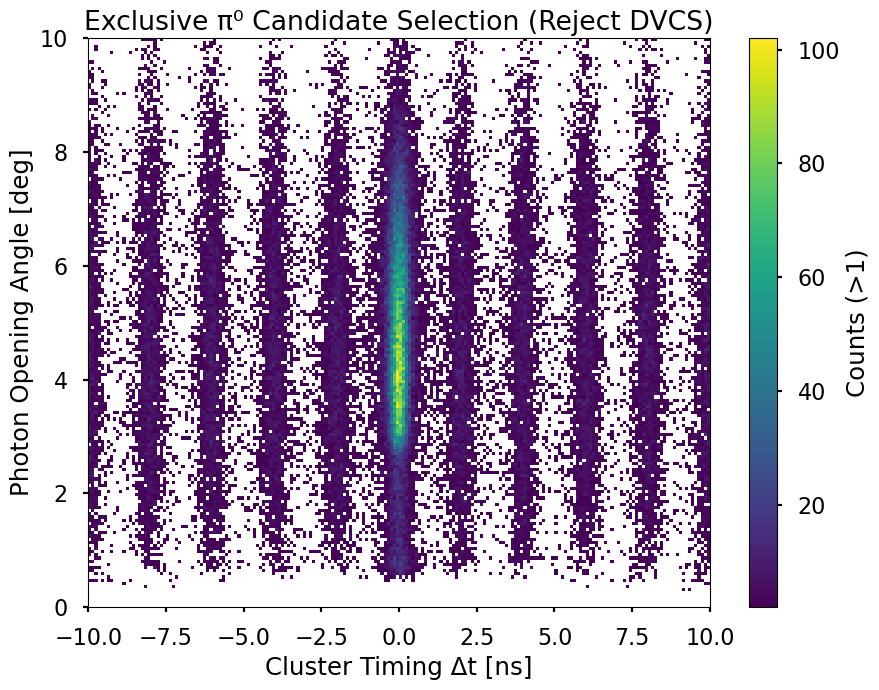

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import itertools

# Load branches
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]
clusX = branches["NPS.cal.clusX"]
clusY = branches["NPS.cal.clusY"]

# --- Apply energy cut ---
mask_energy = clusE > 0.8
clusE_sel = clusE[mask_energy]
clusT_sel = clusT[mask_energy]
clusX_sel = clusX[mask_energy]
clusY_sel = clusY[mask_energy]

# --- Select events with 2 clusters (pi0 candidates) ---
mask_two = ak.num(clusT_sel) >= 2
clusT_two = clusT_sel[mask_two]
clusX_two = clusX_sel[mask_two]
clusY_two = clusY_sel[mask_two]

# --- Compute cluster timing difference ---
dt = clusT_two[:, 1] - clusT_two[:, 0]   # This is already 1D
dt = ak.to_numpy(dt)                     # Convert to NumPy if needed

# --- Compute opening angle between the two photons ---
def opening_angle(x1, y1, x2, y2, z=407.0):  # z = NPS distance in cm
    v1 = np.stack([x1, y1, np.full_like(x1, z)], axis=-1)
    v2 = np.stack([x2, y2, np.full_like(x2, z)], axis=-1)
    dot = np.sum(v1*v2, axis=-1)
    norm1 = np.linalg.norm(v1, axis=-1)
    norm2 = np.linalg.norm(v2, axis=-1)
    return np.arccos(dot/(norm1*norm2)) * 180/np.pi  # in degrees

angles = opening_angle(
    ak.to_numpy(clusX_two[:,0]), ak.to_numpy(clusY_two[:,0]),
    ak.to_numpy(clusX_two[:,1]), ak.to_numpy(clusY_two[:,1])
)

# --- 2D histogram: Timing difference vs Opening angle ---
plt.figure(figsize=(9,7))
count_threshold = 1
counts, xedges, yedges = np.histogram2d(dt, angles, bins=[200, 180], range=[[-10,10], [0,10]])
counts_masked = np.where(counts > count_threshold, counts, np.nan)

X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis')
plt.colorbar(label=f'Counts (>{count_threshold})')

plt.xlabel("Cluster Timing Δt [ns]")
plt.ylabel("Photon Opening Angle [deg]")
plt.title("Exclusive π⁰ Candidate Selection (Reject DVCS)")
plt.tight_layout()
plt.show()


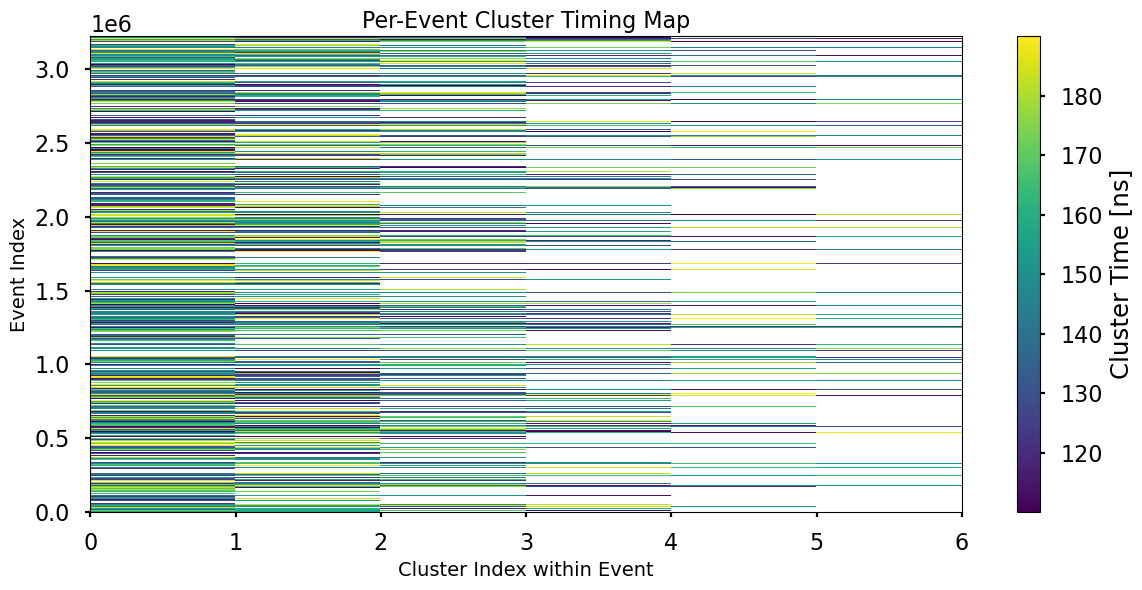

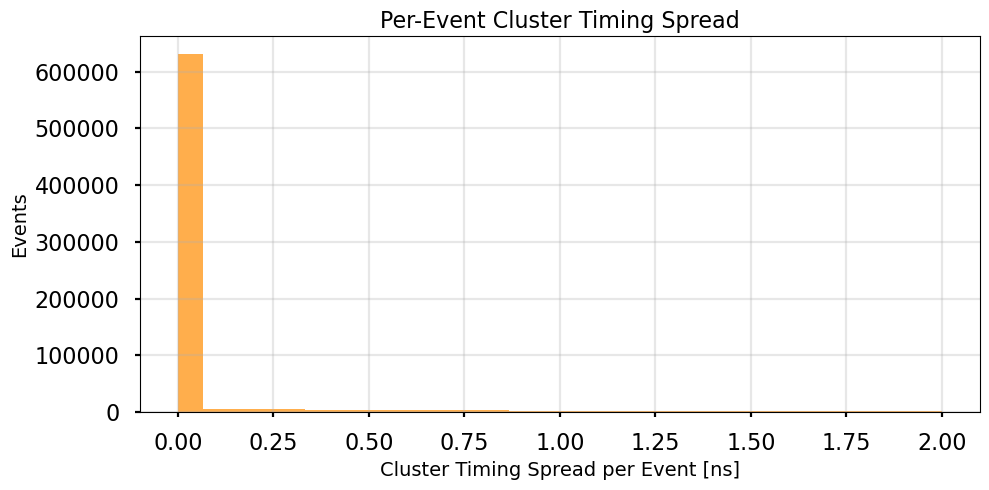

In [34]:
import numpy as np

# Convert jagged to padded array for 2D heatmap
clusT = branches["NPS.cal.clusT"]
max_clusters = 6  # adjust depending on your detector
clusT_padded = ak.to_numpy(ak.fill_none(ak.pad_none(clusT, max_clusters, clip=True), np.nan))

# Compute min, max, and spread of cluster timings per event
timing_min = ak.min(clusT, axis=1)
timing_max = ak.max(clusT, axis=1)
timing_spread = timing_max - timing_min

plt.figure(figsize=(12,6))
plt.imshow(
    clusT_padded, aspect='auto', 
    interpolation='none', cmap='viridis',
    extent=[0, max_clusters, 0, len(clusT)]
)
plt.colorbar(label='Cluster Time [ns]')
plt.xlabel("Cluster Index within Event", fontsize=14)
plt.ylabel("Event Index", fontsize=14)
plt.title("Per-Event Cluster Timing Map", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.hist(timing_spread, bins=30, range=(0,2.0), color="darkorange", alpha=0.7)
plt.xlabel("Cluster Timing Spread per Event [ns]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.title("Per-Event Cluster Timing Spread", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



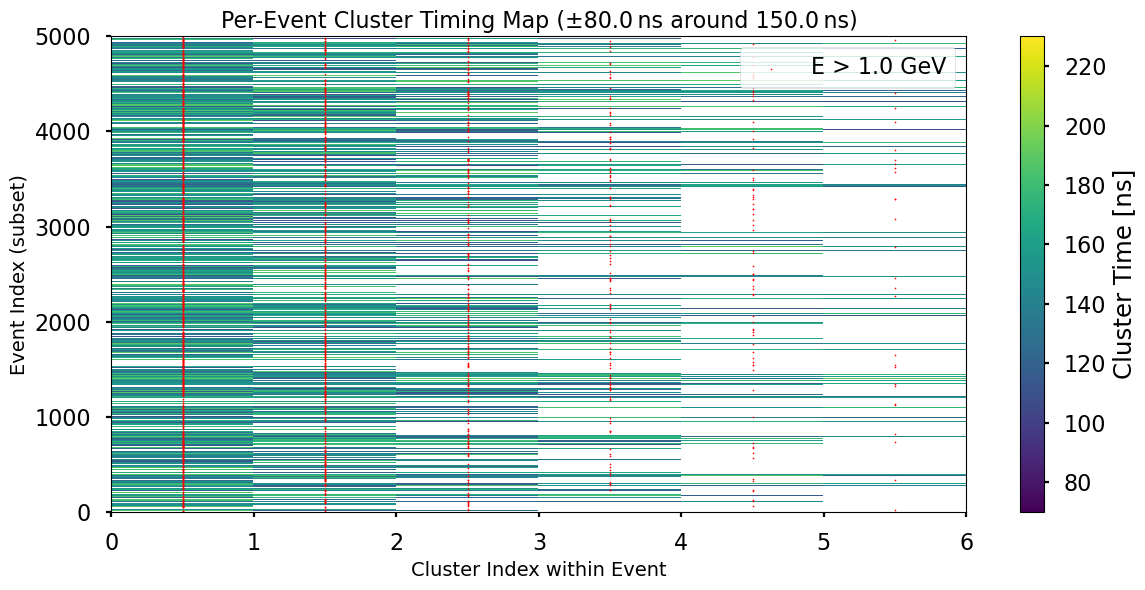

In [74]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# --- Settings ---
energy_cut_high = 1.0   # GeV for red dot overlay
t0 = 150.0              # ns, ideal coincidence time
half_window = 80.0      # ±40 ns window

# --- Downsample events ---
n_show = min(5000, len(clusT))  # max 5k events
clusT_subset = clusT[:n_show]
clusE_subset = clusE[:n_show]

max_clusters = 6  # visualize first 6 clusters per event

# --- Convert Awkward to padded NumPy arrays ---
clusT_padded = ak.to_numpy(
    ak.fill_none(ak.pad_none(clusT_subset, max_clusters, clip=True), np.nan)
)
clusE_padded = ak.to_numpy(
    ak.fill_none(ak.pad_none(clusE_subset, max_clusters, clip=True), 0.0)
)

# --- Mask clusters outside the ±40 ns window around 150 ns ---
mask_window = (clusT_padded >= (t0-half_window)) & (clusT_padded <= (t0+half_window))
clusT_windowed = np.where(mask_window, clusT_padded, np.nan)

# --- Prepare overlay for high-energy clusters ---
highE_mask = (clusE_padded > energy_cut_high) & mask_window
y_indices, x_indices = np.where(highE_mask)
t_highE = clusT_padded[highE_mask]

# --- Plot heatmap ---
plt.figure(figsize=(12, 6))
im = plt.imshow(
    clusT_windowed,
    aspect='auto', interpolation='none', cmap='viridis',
    extent=[0, max_clusters, 0, n_show],
    vmin=t0-half_window, vmax=t0+half_window
)
plt.colorbar(im, label='Cluster Time [ns]')

# --- Overlay high-energy clusters ---
plt.scatter(
    x_indices + 0.5, y_indices,  # offset x by 0.5 to center dots in bins
    c='red', s=.5, label=f"E > {energy_cut_high} GeV"
)

# --- Labels and title ---
plt.xlabel("Cluster Index within Event", fontsize=14)
plt.ylabel("Event Index (subset)", fontsize=14)
plt.title(f"Per-Event Cluster Timing Map (±{half_window} ns around {t0} ns)", fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


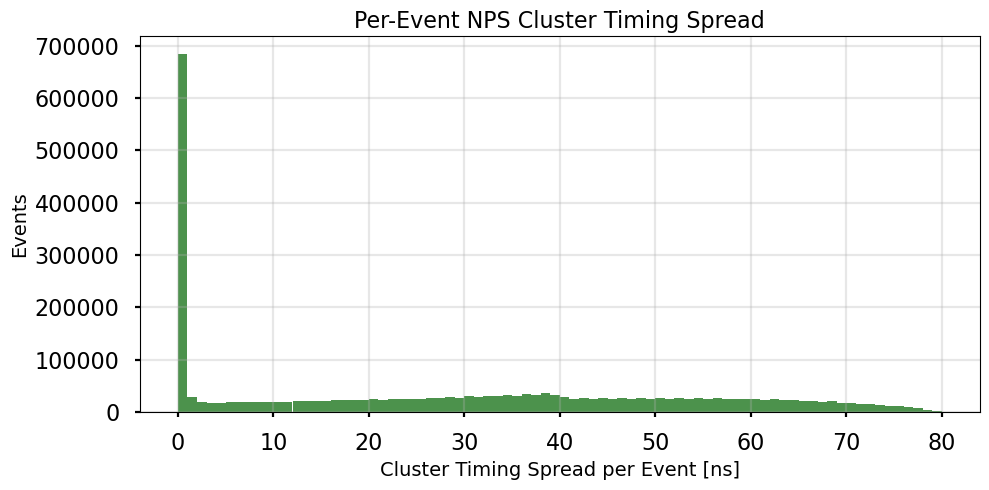

In [46]:
timing_spread = ak.to_numpy(ak.max(clusT, axis=1) - ak.min(clusT, axis=1))

plt.figure(figsize=(10,5))
plt.hist(timing_spread, bins=80, range=(0,80), color="darkgreen", alpha=0.7)
plt.xlabel("Cluster Timing Spread per Event [ns]", fontsize=14)
plt.ylabel("Events", fontsize=14)
plt.title("Per-Event NPS Cluster Timing Spread", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
import colorcet as cc  # <-- for colormaps like 'viridis'

# Example Awkward arrays -> numpy (replace with your actual clusT/clusE)
# clusT: (events, clusters) cluster times
# clusE: (events, clusters) cluster energies

clusT = branches["NPS.cal.clusT"]
clusE = branches["NPS.cal.clusE"]

max_clusters = 6
n_show = min(5000, len(clusT))  # Limit for display

clusT_subset = ak.to_numpy(
    ak.fill_none(ak.pad_none(clusT[:n_show], max_clusters, clip=True), np.nan)
)
clusE_subset = ak.to_numpy(
    ak.fill_none(ak.pad_none(clusE[:n_show], max_clusters, clip=True), 0.0)
)

# --- Settings ---
energy_cut_high = 1.0   # GeV
t0 = 150.0              # ns ideal
half_window = 40.0      # ±40 ns

# --- Filter timing window ---
mask_window = (clusT_subset >= (t0-half_window)) & (clusT_subset <= (t0+half_window))
clusT_windowed = np.where(mask_window, clusT_subset, np.nan)

# --- Flatten for DataFrame ---
n_events, n_clusters = clusT_windowed.shape
event_idx, cluster_idx = np.meshgrid(np.arange(n_events), np.arange(n_clusters), indexing='ij')

df = pd.DataFrame({
    'event': event_idx.flatten(),
    'cluster_idx': cluster_idx.flatten(),
    'time': clusT_windowed.flatten(),
    'energy': clusE_subset.flatten()
}).dropna()

# --- Datashader Canvas ---
cvs = ds.Canvas(plot_width=600, plot_height=600,
                x_range=[0, max_clusters],
                y_range=[0, n_show])

# 1️⃣ Timing heatmap
agg_time = cvs.points(df, 'cluster_idx', 'event', agg=ds.mean('time'))
heatmap_img = tf.shade(agg_time, cmap=cc.cm['viridis'], how='eq_hist')

# 2️⃣ High-energy overlay (red points)
highE_df = df[df['energy'] > energy_cut_high]
agg_highE = cvs.points(highE_df, 'cluster_idx', 'event', agg=ds.any())
overlay_img = tf.shade(agg_highE, cmap=['red'], how='eq_hist')
overlay_img = tf.spread(overlay_img, px=1)  # make dots more visible

# 3️⃣ Combine
final_img = heatmap_img + overlay_img
final_img


KeyError: 'viridis'

# π⁰ Coincidence and Accidental Subtraction

The **main π⁰ coincidence region** in the `[-3, 3] ns` range contains the photons, electrons, and 
accidentals in the dataset. To quantify the number of **accidental H(e,eπ⁰)X triple coincidences**, 
we measure the number of **two-photon events** detected in the calorimeter for each of the 
following three timing windows with respect to the **scattered electron detected in the Left-HRS**:

1. **Main coincidence window:** `[-3, 3] ns`  
2. **Early sideband:** `[-11, -5] ns`  
3. **Late sideband:** `[5, 11] ns`  

Each event can have **one photon in-time** and **one out-of-time**, or **both photons out-of-time**.

---

The **DVCS analysis** uses the **opposite approach** where an **accidental π⁰ subtraction** is 
needed: accidental events occur when

- The two photons are **in time with each other** (forming a π⁰-like pair),
- But **out-of-time with the electron**.

---

We define the notation:

$
N_{e'X,\gamma_1Y,\gamma_2Z}
$

Where:

- `X`, `Y`, `Z` can be either:
  - **C**: In-coincidence (Cluster within [-3, 3] ns of the electron)
  - **A**: Accidental (Cluster in sidebands)

For example:

- $ $N_{e'C\gamma_1C\gamma_2C} $ → Electron and both photons in coincidence  
  **→ Represents the main π⁰ peak.**

---

### Five possible timing combinations:

1. **Pure randoms**  
   $
   N_{e'A\gamma_1A\gamma_2A} \quad \text{(both photons accidental)}
   $

2. **Diagonal band (photon-photon coincidence, electron accidental)**  
   $
   N_{e'A\gamma_1C\gamma_2C}
   $

3. **Vertical band (electron-photon1 coincidence, photon2 accidental)**  
   $
   N_{e'C\gamma_1C\gamma_2A}
   $

4. **Horizontal band (electron-photon2 coincidence, photon1 accidental)**  
   $
   N_{e'C\gamma_1A\gamma_2C}
   $

5. **Main π⁰ coincidence**  
   $
   N_{e'C\gamma_1C\gamma_2C}
   \quad \text{(all three in coincidence)}
   $

---

### Accidental Subtraction

To compute the **number of accidental π⁰ events**, we use:

$
N_{\text{Accidentals } \pi^0} =
N_{e'A\gamma_1C\gamma_2C}
+ \frac{1}{2} \Big( N_{e'C\gamma_1C\gamma_2A} + N_{e'C\gamma_1A\gamma_2C} \Big)
- N_{e'A\gamma_1A\gamma_2A}
$

Then, the **true π⁰ count after background subtraction** is:

$
N_{\text{Good } \pi^0} =
N_{e'C\gamma_1C\gamma_2C} - N_{\text{Accidentals } \pi^0}
$

---

This procedure allows us to **extract clean exclusive π⁰ events** by systematically 
subtracting **accidentals** from the main coincidence peak.


# Missing mass reconstruction 

# 🧭 Coordinate Transformations in Hall C (Jefferson Lab)

This notebook uses a series of rotations to transform momentum vectors between coordinate systems used in Hall C:

## 🔁 Coordinate Systems

| System                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| **Hall (h)**           | Global frame:  
                         - \(+z_h\): along beam direction  
                         - \(+x_h\): beam-left  
                         - \(+y_h\): vertical up (ceiling) |
| **Spectrometer (s)**   | Aligned with spectrometer central ray:  
                         - \(+z_s\): along spectrometer axis (rotated by θ)  
                         - \(+x_s\): dispersive (toward floor)  
                         - \(+y_s\): non-dispersive (beam-left) |
| **Detector Hut (d)**   | Local detector frame:  
                         - Rotated from spectrometer frame by 25° about \(y_s\)  
                         - \(+z_d\): along dipole bend direction |

---

## 🔄 HMS Electron: Detector Hut → Hall Coordinates

For HMS (to right of beam), apply **inverse rotations**:

1. **Rotate +25° about y-axis**  
   → detector hut → spectrometer  
   `rotate_y(p_vec, 25)`

2. **Rotate +90° about z-axis**  
   → spectrometer → intermediate (undo -90°)  
   `rotate_z(p_spec, 90)`

3. **Rotate +θ about y-axis**  
   → undo spectrometer central angle (e.g., θ = 19.36°)  
   `rotate_y(p_spec, theta_deg)`

---

## 🔄 NPS Photon: Spectrometer → Hall Coordinates

For NPS (to left of beam), apply:

1. **Rotate +90° about z-axis**  
   → spectrometer → intermediate  
   `rotate_z(p_vec, 90)`

2. **Rotate −θ about y-axis**  
   → undo spectrometer angle (e.g., θ = 17.5°)  
   `rotate_y(p_spec, -theta_deg)`

---

## 🧮 Detector Hut Origin Offset

The origin of the detector hut system is **offset** from the Hall origin by distance **L** along the spectrometer axis:

```python
def detector_origin_in_hall(L, theta_deg):
    x = L * sin(θ)
    z = L * cos(θ)


In [118]:
# passive transformations since the coordinate system is being rotated; COUNTER/ANTI CLOCKWISE rotation of axes
def rotate_x(vec, theta_deg):
    theta = np.radians(theta_deg)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta), np.sin(theta)],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return Rx @ vec

def rotate_y(vec, theta_deg): 
    theta = np.radians(theta_deg)
    Ry = np.array([
        [np.cos(theta), 0, -np.sin(theta)],
        [0, 1, 0],
        [np.sin(theta), 0, np.cos(theta)]
    ])
    return Ry @ vec

def rotate_z(vec, theta_deg):
    theta = np.radians(theta_deg)
    Rz = np.array([
        [np.cos(theta), np.sin(theta), 0],
        [-np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return Rz @ vec

def detector_origin_in_hall(L, theta_deg):
    theta = np.radians(theta_deg)
    x = L * np.sin(theta)
    y = 0
    z = L * np.cos(theta)
    return np.array([x, y, z])


def detector_hut_to_hall(px, py, pz, theta_deg): #HMS to the right of beamline
    # Compose all inverse rotations
    p_vec = np.array([px, py, pz])
    # p_spec = rotate_y(p_vec, -25)         # Detector → Spectrometer # this one has to be an active rotation as the electron vector is "artificially bent" for the spectrometer.
    #artificial because that's not because of the scattering. not needed as bothe the coordinate axes and the electron vector are rotated.
    p_spec = rotate_z(p_vec, 90)        # Spec → Hall (undo -90°)
    p_hall = rotate_y(p_spec, theta_deg)  # Undo spectrometer angle θ
    return p_hall

def nps_to_hall(px, py, pz, theta_deg): #NPS to the left of beamline
    # Compose all inverse rotations
    p_vec = np.array([px, py, pz])
    # p_hall = rotate_z(p_vec, 90)        # Spec → Hall (undo -90°)
    p_hall = rotate_y(p_vec, theta_deg)  # Undo spectrometer angle θ

    # p_hall = rotate_y(np.array([px, py, pz]), theta_deg)
    # # Step 2: Undo rotation from detector to spectrometer (rotate around Z by -90°)
    # p_hall = rotate_z(p_hall, -90)
    return p_hall

# def detector_hut_to_hall_with_translation(px, py, pz, L=18.1, theta_deg=16.5): # check units of L
#     # 1. Rotate from detector hut to hall
#     p_rot = detector_hut_to_hall(px, py, pz, theta_deg)

#     # 2. Translate from detector hut origin to hall origin
#     origin_shift = detector_origin_in_hall(L, theta_deg)

#     # 3. Return full momentum vector (no need to shift momentum itself, but position vectors would be shifted)
#     return p_rot  # Use origin_shift if you're dealing with positions


In [121]:
# --- HMS and NPS cut helpers ---
def pass_hms_cuts(edt, dp, etrnorm, npe, th, ph):
    return (edt < 0.1 and abs(dp) <= 8.5 and abs(etrnorm - 1) < 0.1 and npe > 1.0 and
            abs(th) <= 0.09 and abs(ph) <= 0.09)

def is_good_cluster(e, t, x, y):
    return (e >= 0.6 and 148 <= t <= 152 and
            -29.16 < x < 29.16 and -35.64 < y < 35.64)

def get_photon_4vector(E, x, y, z_nps=407): #z_nps in cm
    r = np.array([x, y, z_nps])
    u = r / np.linalg.norm(r)
    p = E * u
    return np.array([E, *p])

def check_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407, theta_tolerance_rad=0.02): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2

    # Opening angle cut
    s = 4 * e1 * e2
    arg = M_PION0 / np.sqrt(s)
    if arg < -1 or arg > 1:
        return False  # reject unphysical event
    theta_ideal = 2 * np.arcsin(arg)

    # theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    theta_tolerance_rad = theta_tolerance_rad # 0.02 considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        return 1
    

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import numba as nb
import pandas as pd
from tqdm import tqdm

# Constants
m_e = 0.000511
m_p = 0.938
E_beam = 10.537  # GeV
z_nps = 407     # cm

# @nb.njit

# Beam and target 4-vectors in lab frame
p4_ein = np.array([E_beam, 0, 0, E_beam])
p4_pin = np.array([m_p, 0, 0, 0])

# Event selection: ≥2 clusters
has_two_clust = ak.num(branches["NPS.cal.clusE"]) >= 2

# Extract variables (only for selected events)
edt  = ak.to_numpy(branches["T.hms.hEDTM_tdcTimeRaw"])[has_two_clust]
dp   = ak.to_numpy(branches["H.gtr.dp"])[has_two_clust]
et   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust] # using momentum as the energy
etrnorm = ak.to_numpy(branches["H.cal.etracknorm"])[has_two_clust]
npe  = ak.to_numpy(branches["H.cer.npeSum"])[has_two_clust]
th   = ak.to_numpy(branches["H.gtr.th"])[has_two_clust]
ph   = ak.to_numpy(branches["H.gtr.ph"])[has_two_clust]
pe   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust]
px_e = ak.to_numpy(branches["H.gtr.px"])[has_two_clust]
py_e = ak.to_numpy(branches["H.gtr.py"])[has_two_clust]
pz_e = ak.to_numpy(branches["H.gtr.pz"])[has_two_clust]
Ee   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust] # using momentum as the energy

# Cluster info (still jagged arrays)
clusE = branches["NPS.cal.clusE"][has_two_clust]
clusX = branches["NPS.cal.clusX"][has_two_clust]
clusY = branches["NPS.cal.clusY"][has_two_clust]
clusT = branches["NPS.cal.clusT"][has_two_clust]

missing_mass_w_opening_angle = []
missing_mass_all = []
# Loop over events
# for i in range(len(pe)):
for i in tqdm(range(len(pe)), desc="Processing events"):
    # if not pass_hms_cuts(edt[i], dp[i], et[i], npe[i], th[i], ph[i]):
    #     continue
    if Ee[i] < 3.5:
        continue
# transforming from HMS detector hut coordinates to hall coordinates
    # p_hall = detector_hut_to_hall(px_e[i], py_e[i], pz_e[i], theta_deg=19.36)
    # px_ehall, py_ehall, pz_ehall = p_hall[0], p_hall[1], p_hall[2]

    # # Scattered electron 4-vector
    # # p4_eout = np.array([Ee[i], px_ehall[i], py_ehall[i], pz_ehall[i]])
    # p4_eout = np.array([Ee[i], px_ehall, py_ehall, pz_ehall])

    # Get this event's clusters

    p4_eout = np.array([
        Ee[i],                          # energy
        px_e[i],                  # px
        py_e[i],                  # py
        pz_e[i]  # pz
    ])    
    # p4_eout = np.array([
    #     Ee[i],                          # energy
    #     Ee[i] * ph[i],                  # px
    #     Ee[i] * th[i],                  # py
    #     Ee[i] * (1.0 - 0.5*(th[i]**2 + ph[i]**2))  # pz
    # ])


    e_arr = np.array(clusE[i])
    x_arr = np.array(clusX[i])
    y_arr = np.array(clusY[i])
    t_arr = np.array(clusT[i])

    if len(e_arr) < 2:
        continue

    # Sort cluster indices by energy (descending)
    idx = np.argsort(e_arr)[-2:]

    # Select two most energetic clusters
    e1, e2 = e_arr[idx[1]], e_arr[idx[0]]
    x1, x2 = x_arr[idx[1]], x_arr[idx[0]]
    y1, y2 = y_arr[idx[1]], y_arr[idx[0]]
    t1, t2 = t_arr[idx[1]], t_arr[idx[0]]

    # if not (is_good_cluster(e1, t1, x1, y1) and is_good_cluster(e2, t2, x2, y2)):
    #     continue



    if not pass_hms_cuts(edt[i], dp[i], etrnorm[i], npe[i], th[i], ph[i]):
        continue

    if not (is_good_cluster(e1, t1, x1, y1) & is_good_cluster(e2, t2, x2, y2)):
        continue

    # if not check_opening_angle(e1, e2, x1, y1, x2, y2):
    #     continue







    # π⁰ 4-vector from 2 photons
    # Build photon 4-vectors in hall frame individually
    photon1 = get_photon_4vector(e1, x1, y1)
    photon2 = get_photon_4vector(e2, x2, y2)

    # Rotate photon momenta to hall frame
    # NPS to the left of beam thus require a CLOCKWISE rotation of axes
    p1x, p1y, p1z = nps_to_hall(photon1[1], photon1[2], photon1[3], theta_deg=-17.51) 
    p2x, p2y, p2z = nps_to_hall(photon2[1], photon2[2], photon2[3], theta_deg=-17.51)

    # Construct full 4-vectors
    p4_ph1 = np.array([photon1[0], p1x, p1y, p1z])
    p4_ph2 = np.array([photon2[0], p2x, p2y, p2z])

    # Add to get pion
    p4_pi = p4_ph1 + p4_ph2

    # p4_pi = photon1 + photon2


    # Final state and missing 4-momentum
    p4_out = p4_eout + p4_pi
    p4_miss = (p4_ein + p4_pin) - p4_out
    m2_miss = p4_miss[0]**2 - np.dot(p4_miss[1:], p4_miss[1:])
    # if m2_miss < -1:
    #     temp1 = p4_pi[0]**2 - np.dot(p4_pi[1:], p4_pi[1:])
    #     temp2 = p4_pin[0]**2 - np.dot(p4_pin[1:], p4_pin[1:])
    #     temp3 = p4_ein[0]**2 - np.dot(p4_ein[1:], p4_ein[1:])
    #     temp4 = p4_eout[0]**2 - np.dot(p4_eout[1:], p4_eout[1:])
    #     print(f"incoming electron: {np.sqrt(temp3)}, incoming proton: {np.sqrt(temp2)}, scattered electron^2: {temp4}, pion: {np.sqrt(temp1)}")
        # print(f"total in: {p4_ein + p4_pin}, square: {(p4_ein + p4_pin)[0]**2 - (p4_ein + p4_pin)[3]**2}")
        # print(f"eout unrotated: {Ee[i], px_e[i], py_e[i], pz_e[i]}, square: {Ee[i]**2 - px_e[i]**2 - py_e[i]**2 - pz_e[i]**2}")
        # print(f"eout 4vec: {p4_eout}, square: {p4_eout[0]**2 - p4_eout[1]**2 - p4_eout[2]**2 - p4_eout[3]**2}")
        # print(f"pi 4vec:   {p4_pi}, square root: {np.sqrt(p4_pi[0]**2 - p4_pi[1]**2 - p4_pi[2]**2 - p4_pi[3]**2)}")
        # print(f"total out: {p4_out}, square: {p4_out[0]**2 - p4_out[1]**2 - p4_out[2]**2 - p4_out[3]**2}")
        # print(f"miss 4vec: {p4_miss}")
        # print(f"m²_miss:   {m2_miss:.4f}")
    #     print(f"photons original: {photon1}; {photon2}")




        # print(f"BAD m²_miss = {m2_miss:.2f}, px={p4_out[1]:.2f}, py={p4_out[2]:.2f}, pz={p4_out[3]:.2f}")

    # print(m2_miss)
    # m_miss = np.sqrt(m2_miss) if m2_miss > 0 else 0
    if check_opening_angle(e1, e2, x1, y1, x2, y2, theta_tolerance_rad=0.02):
        missing_mass_w_opening_angle.append(m2_miss)

    missing_mass_all.append(m2_miss)


    df_all = pd.DataFrame(missing_mass_all)
    df_w_opening_angle = pd.DataFrame(missing_mass_w_opening_angle)

    df_all.to_csv("missing_mass_sq_all.csv", mode = 'w', index=False)
    df_w_opening_angle.to_csv("missing_mass_sq_w_openging_angle.csv", mode = 'w', index=False)

Processing events:   0%|          | 0/1867180 [00:00<?, ?it/s]/tmp/ipykernel_179692/1114992343.py:76: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e_arr = np.array(clusE[i])
/tmp/ipykernel_179692/1114992343.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_arr = np.array(clusX[i])
/tmp/ipykernel_179692/1114992343.py:78: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' 

/tmp/ipykernel_9354/802044689.py:13: RuntimeWarning: invalid value encountered in sqrt
  hist_all, _ = np.histogram(np.sqrt(missing_mass_all), bins=bins)
/tmp/ipykernel_9354/802044689.py:14: RuntimeWarning: invalid value encountered in sqrt
  hist_cut, _ = np.histogram(np.sqrt(missing_mass_w_opening_angle), bins=bins)
/tmp/ipykernel_9354/802044689.py:35: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(missing_mass_all), bins=bins, color='gray', histtype='step',
/tmp/ipykernel_9354/802044689.py:37: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(missing_mass_w_opening_angle), bins=bins, color='darkblue', alpha=0.5,


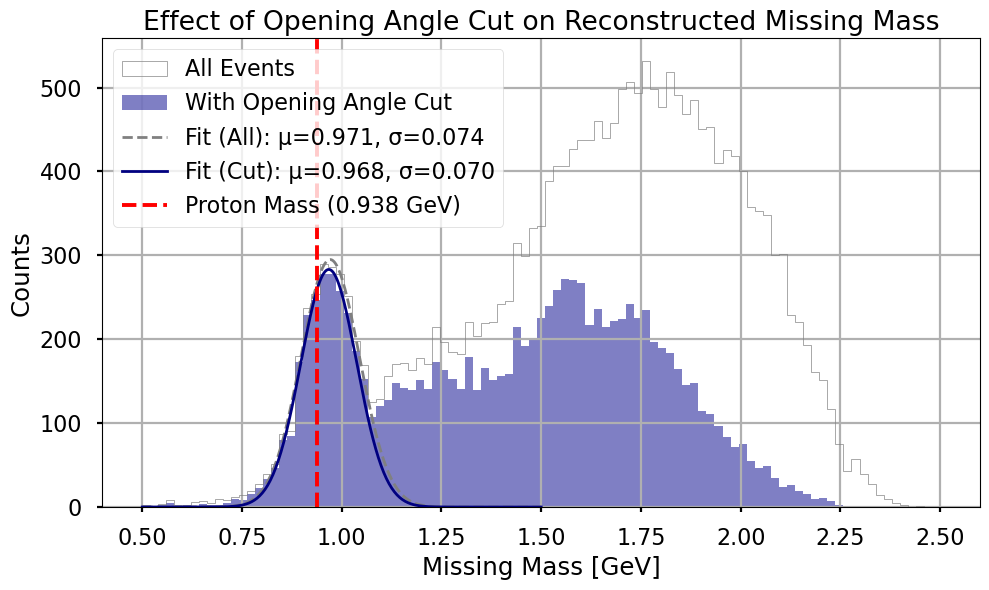

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define binning
bins = np.linspace(0.5, 2.5, 100)

# Histogram both datasets
hist_all, _ = np.histogram(np.sqrt(missing_mass_all), bins=bins)
hist_cut, _ = np.histogram(np.sqrt(missing_mass_w_opening_angle), bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

# === Fit both distributions in region near proton mass ===
fit_mask = (bin_centers > 0.8) & (bin_centers < 1.02)

# Fit without cut
popt_all, _ = curve_fit(gaussian, bin_centers[fit_mask], hist_all[fit_mask], 
                        p0=[np.max(hist_all), 0.938, 0.02])

# Fit with cut
popt_cut, _ = curve_fit(gaussian, bin_centers[fit_mask], hist_cut[fit_mask], 
                        p0=[np.max(hist_cut), 0.938, 0.02])

# Generate smooth curves
x_smooth = np.linspace(0.5, 1.5, 300)
y_fit_all = gaussian(x_smooth, *popt_all)
y_fit_cut = gaussian(x_smooth, *popt_cut)

# === Plot both distributions ===
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(missing_mass_all), bins=bins, color='gray', histtype='step', 
         lw=2, label='All Events')
plt.hist(np.sqrt(missing_mass_w_opening_angle), bins=bins, color='darkblue', alpha=0.5, 
         label='With Opening Angle Cut')

plt.plot(x_smooth, y_fit_all, 'gray', linestyle='--', lw=2, 
         label=f'Fit (All): μ={popt_all[1]:.3f}, σ={popt_all[2]:.3f}')
plt.plot(x_smooth, y_fit_cut, 'navy', linestyle='-', lw=2, 
         label=f'Fit (Cut): μ={popt_cut[1]:.3f}, σ={popt_cut[2]:.3f}')

plt.axvline(0.938, color='red', linestyle='--', label='Proton Mass (0.938 GeV)')

plt.xlabel("Missing Mass [GeV]")
plt.ylabel("Counts")
plt.title("Effect of Opening Angle Cut on Reconstructed Missing Mass")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
